In [1]:
from __future__ import division
#locations, locations
#Georgi's CISBP list grepped for SPI1:
spi1_cisbp_hits = "/home/ktian/kundajelab/tfnet/results/nandi/CIS-BP/data/SPI1.txt"
#1kb around SPI1 GM12878 summits:
spi1_summits_and_flank_coords = "/srv/scratch/ktian/kundajelab/tfmodisco_bio_experiments/results/nandi/SPI1/SPI1_GM12878_18_08_31/interpret.tsv"
spi1_summits_and_flank_fa = "/srv/scratch/ktian/kundajelab/tfmodisco_bio_experiments/results/nandi/SPI1/SPI1_GM12878_18_08_31/interpret.fa"
hyp_scores = "/home/ktian/kundajelab/tfnet/results/nandi/SPI1/SPI1_GM12878_refine_18_09_04/scores/hyp_scores_task_0.npy"
spi1_bqtls = "/home/ktian/kundajelab/tfnet/results/nandi/bQTL/analysis/bQTL_all_SNPs/SPI1.txt"

In [2]:
import numpy as np
pwm_name_to_matrix = {
    "M4475_1.02": np.array([
[0.347561,0.211382,0.27439,0.166667],
[0.504065,0.083333,0.304878,0.107724],
[0.727642727642728,0.0426830426830427,0.0833330833330833,0.146341146341146],
[0.735772735772736,0.0284550284550285,0.121951121951122,0.113821113821114],
[0.674797,0.00813,0.081301,0.235772],
[0.113821,0.04878,0.823171,0.014228],
[0.636179,0.073171,0.29065,0.0],
[0.087398,0.0,0.912602,0.0],
[0.002033,0.0,0.997967,0.0],
[1.0,0.0,0.0,0.0],
[0.987804012195988,0.00203299796700203,0.0,0.0101629898370102],
[0.020325,0.325203,0.654472,0.0],
[0.026423,0.0,0.004065,0.969512],
[0.004065,0.018293,0.977642,0.0],
[0.689024,0.069106,0.21748,0.02439],
[0.514228,0.073171,0.313008,0.099593],
[0.729675,0.105691,0.083333,0.081301],
[0.231707,0.367886,0.268293,0.132114],
[0.245935245935246,0.274390274390274,0.142276142276142,0.337398337398337]]),

"HOMER_denovo": np.array([[0.465,0.098,0.216,0.221],
[0.538,0.079,0.164,0.219],
[0.497,0.037,0.180,0.286],
[0.222,0.157,0.571,0.050],
[0.506,0.154,0.280,0.060],
[0.140,0.001,0.858,0.001],
[0.045,0.001,0.953,0.001],
[0.994,0.001,0.001,0.004],
[0.969,0.001,0.001,0.029],
[0.055,0.283,0.654,0.008],
[0.063,0.132,0.028,0.777],
[0.109,0.145,0.693,0.053]])

}

In [3]:
from collections import defaultdict

##filter the SPI1 bQTLs for the ones that are in the 1kb summits
spi1_bqtls_in_1kb = "spi1_bqtls_in_1kb.txt"
! ./filter_bqtls_to_be_in_region.sh $spi1_bqtls $spi1_summits_and_flank_coords > $spi1_bqtls_in_1kb

In [4]:
from collections import defaultdict, namedtuple
import numpy as np

#read in all the region coordinates and create a map from coordinate to index
region_coord_to_idx = {}
for i,line in enumerate(open(spi1_summits_and_flank_coords)):
    chrom,start,end = line.rstrip().split("\t")
    region_coord_to_idx[chrom+":"+start+"-"+end] = i
total_regions = max(region_coord_to_idx.values())+1

BQTL = namedtuple("BQTL", ["chrom", "chrom_start", "region_idx", "offset", "alt_allele", "post_allele", "pval"])
    
region_idx_to_bqtls = defaultdict(list)
all_bqtls = []
    
#read in all the bqtl info, get the bQTL coordinates relative to the region starts
for line in open(spi1_bqtls_in_1kb):
    bqtl_chrom,bqtl_start,bqtl_end,alt_allele,post_allele,pval,region_chrom,region_start,region_end = line.rstrip().split("\t")
    bqtl_start = int(bqtl_start)
    bqtl_end = int(bqtl_end)
    pval = float(pval)
    region_idx = region_coord_to_idx[region_chrom+":"+region_start+"-"+region_end]
    region_start = int(region_start)
    region_end = int(region_end)    
    offset_from_start = bqtl_start-region_start
    assert bqtl_chrom==region_chrom
    assert offset_from_start >= 0 and offset_from_start <= 1000
    bqtl = BQTL(chrom=bqtl_chrom, chrom_start=bqtl_start,
                region_idx=region_idx, offset=offset_from_start,
                alt_allele=alt_allele, post_allele=post_allele, pval=pval)
    all_bqtls.append(bqtl)
    region_idx_to_bqtls[region_idx].append(bqtl)

In [5]:
#read in the hyp contribs
hypcontribs = np.load(hyp_scores)
assert len(hypcontribs)==total_regions

In [6]:

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the DNA sequence at these regions, one-hot encode
fasta_sequences = []
for i,a_line in enumerate(open(spi1_summits_and_flank_fa)):
    if (i%2 == 1):
        a_line = a_line.rstrip()
        fasta_sequences.append(a_line)
onehot_data = np.array([one_hot_encode_along_channel_axis(seq)
                        for seq in fasta_sequences])
print(onehot_data.shape)

#compute the background ACGT frequency
acgt_freqs = np.mean(onehot_data, axis=(0,1))
print(acgt_freqs)

(38932, 1000, 4)
[0.27314001 0.22642602 0.22654033 0.27386911]


In [7]:
from scipy.signal import correlate2d
import sys

pwm_scores = {}
#scan all the sequences using the PWMs (pad the ends as needed)
print("Scanning with pwms")
sys.stdout.flush()
for pwm_name in pwm_name_to_matrix:
    log_odds_pwm = np.log(pwm_name_to_matrix[pwm_name]/acgt_freqs[None,:] + 0.0000001)
    pwm_scores[pwm_name] = np.pad(np.squeeze(np.array([
                                    np.maximum(correlate2d(in1=x,in2=log_odds_pwm,mode="valid"),
                                               correlate2d(in1=x,in2=log_odds_pwm[::-1,::-1],mode="valid"))
                                              for x in onehot_data])),
                                  pad_width=[(0,0), (int((len(log_odds_pwm)-1)/2),
                                                     (len(log_odds_pwm)-1)-int((len(log_odds_pwm)-1)/2))],
                                  mode='constant')

print(pwm_scores['M4475_1.02'].shape)

Scanning with pwms
(38932, 1000)


In [8]:
#get the hyp contrib predicted delta
bqtl_hypcontrib_delta = []
bqtl_position_max_delta = []
bqtl_nearby_importance = []
bqtl_neglog10_pvalues = []
bqtl_pwm_scores = defaultdict(list)
letter_to_idx = {'A':0, 'C':1, 'G':2, 'T':3}
half_window_size = 20
for bqtl in all_bqtls:
    #if (abs(bqtl.offset - 500) > 200):
    alt_letter_idx = letter_to_idx[bqtl.alt_allele]
    post_letter_idx = letter_to_idx[bqtl.post_allele]
    assert onehot_data[bqtl.region_idx, bqtl.offset, post_letter_idx]==1
    
    bqtl_hypcontrib_delta.append(hypcontribs[bqtl.region_idx, bqtl.offset, post_letter_idx]
                                 - hypcontribs[bqtl.region_idx, bqtl.offset, alt_letter_idx])
    bqtl_position_max_delta.append(np.max(hypcontribs[bqtl.region_idx, bqtl.offset])
                                   - np.min(hypcontribs[bqtl.region_idx, bqtl.offset]))
    bqtl_nearby_importance.append(np.sum(np.abs(hypcontribs[bqtl.region_idx,
                                                            max(bqtl.offset-half_window_size,0):
                                                            (bqtl.offset+half_window_size)])))
    bqtl_neglog10_pvalues.append(-np.log(bqtl.pval)/np.log(10))

    #max pwm scores within half_window_sizebp on either side
    for pwm_name in pwm_scores:
        bqtl_pwm_scores[pwm_name].append(np.max(pwm_scores[pwm_name][bqtl.region_idx,
                                                                 max(bqtl.offset-half_window_size,0):
                                                                 (bqtl.offset+half_window_size)])) 
    
bqtl_hypcontrib_delta = np.array(bqtl_hypcontrib_delta)
bqtl_position_max_delta = np.array(bqtl_position_max_delta)
bqtl_nearby_importance = np.array(bqtl_nearby_importance)
bqtl_neglog10_pvalues = np.array(bqtl_neglog10_pvalues)
bqtl_pwm_scores = dict([(x,np.array(y)) for x,y in bqtl_pwm_scores.items()])

In [9]:
def percentile_normalize(vals):
    sorted_vals = sorted(enumerate(vals), key=lambda x: x[1])
    original_ordering = [x[0] for x in sorted_vals]
    sorted_val_percentiles = np.arange(len(sorted_vals))/len(sorted_vals)
    return np.array([x[0] for x in sorted(zip(sorted_val_percentiles,original_ordering), key=lambda x: x[1])])

percnormed_bqtl_hypcontrib_delta = percentile_normalize(np.abs(bqtl_hypcontrib_delta))
percnormed_bqtl_nearby_importance = percentile_normalize(bqtl_nearby_importance)
percnormed_bqtl_neglog10_pvalues = percentile_normalize(bqtl_neglog10_pvalues)
percnormed_prod_hypcontrib_nearbyimp_percentile = percentile_normalize(percnormed_bqtl_nearby_importance
                                                                       *percnormed_bqtl_hypcontrib_delta)
percnormed_bqtl_pwm_scores = dict([(pwm_name, percentile_normalize(bqtl_pwm_scores[pwm_name]))
                              for pwm_name in bqtl_pwm_scores])

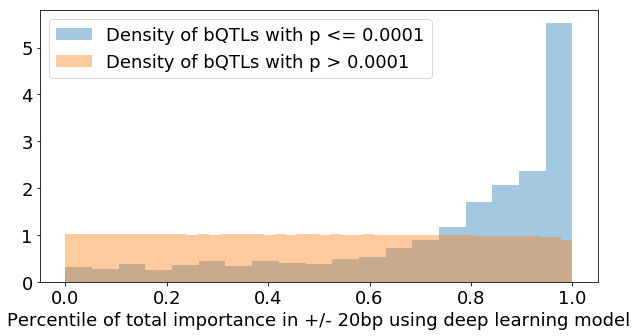

HOMER_denovo


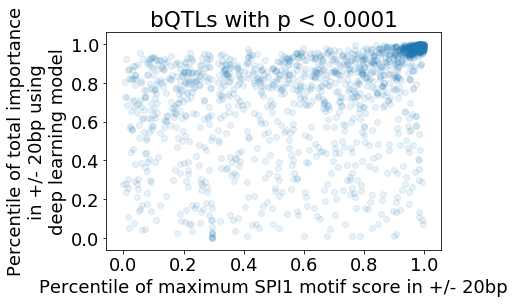

M4475_1.02


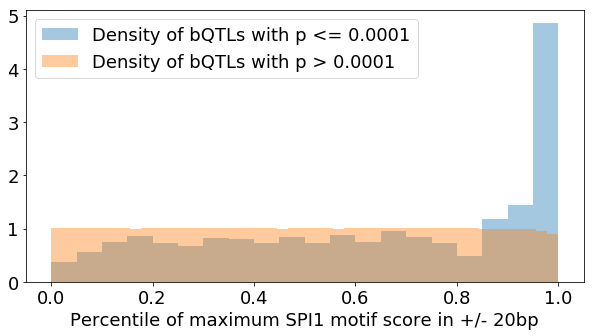

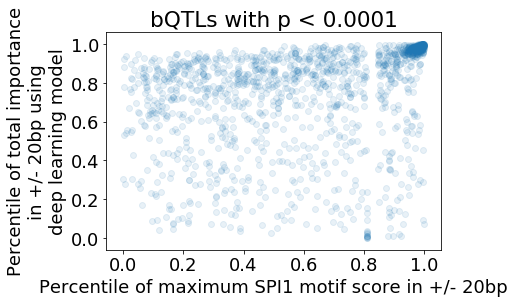

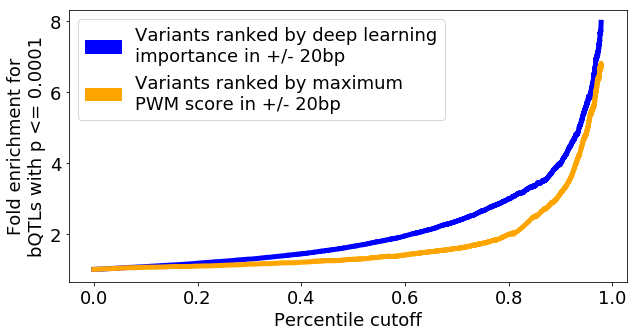

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
import matplotlib.patches as mpatches

#plt.hist(percnormed_min_hypcontrib_nearbyimp_percentile[bqtl_neglog10_pvalues > 4], bins=100)
#plt.show()

def get_observed_enrichment_over_expected(positives_labels, sorting_vals):
    the_len = len(positives_labels)
    num_pos = np.sum(positives_labels)
    frac_pos = num_pos/the_len
    observed_enrichment_vs_expected = ((num_pos-np.cumsum(np.array([x[0] for x in
                                                          sorted(zip(positives_labels, sorting_vals),
                                                                 key=lambda x: x[1])])))/(
                                        the_len-np.arange(len(sorting_vals))))/frac_pos
    return observed_enrichment_vs_expected
    

import matplotlib

font = {'size'   : 18}
matplotlib.rc('font', **font)

#sns.distplot(percnormed_bqtl_hypcontrib_delta[bqtl_neglog10_pvalues >= 4], kde=False, norm_hist=True)
#sns.distplot(percnormed_bqtl_hypcontrib_delta[bqtl_neglog10_pvalues < 4], kde=False, norm_hist=True)
#plt.show()

#sns.distplot(percnormed_prod_hypcontrib_nearbyimp_percentile[bqtl_neglog10_pvalues >= 4], kde=False, norm_hist=True)
#sns.distplot(percnormed_prod_hypcontrib_nearbyimp_percentile[bqtl_neglog10_pvalues < 4], kde=False, norm_hist=True)
#plt.show()

handles = []
plt.figure(figsize=(10,5))
handles.append(sns.distplot(percnormed_bqtl_nearby_importance[bqtl_neglog10_pvalues >= 4], kde=False, norm_hist=True))
handles.append(sns.distplot(percnormed_bqtl_nearby_importance[bqtl_neglog10_pvalues < 4], kde=False, norm_hist=True))
plt.legend(handles, labels=["Density of bQTLs with p <= 0.0001", "Density of bQTLs with p > 0.0001"])
plt.xlabel("Percentile of total importance in +/- 20bp using deep learning model")
plt.show()


#handles = []
#plt.figure(figsize=(10,5))
#handles.append(sns.distplot(bqtl_nearby_importance[bqtl_neglog10_pvalues >= 4], kde=False, norm_hist=True))
#handles.append(sns.distplot(bqtl_nearby_importance[bqtl_neglog10_pvalues < 4], kde=False, norm_hist=True))
#plt.legend(handles, labels=["Density of bQTLs with p <= 0.0001", "Density of bQTLs with p > 0.0001"])
#plt.xlabel("Total importance in +/- 20bp using deep learning model")
#plt.show()

for pwm_name in percnormed_bqtl_pwm_scores:
    the_len = len(bqtl_neglog10_pvalues)
    print(pwm_name)
    handles = []
    plt.figure(figsize=(10,5))
    handles.append(sns.distplot(percnormed_bqtl_pwm_scores[pwm_name][bqtl_neglog10_pvalues >= 4], bins=20, kde=False, norm_hist=True))
    handles.append(sns.distplot(percnormed_bqtl_pwm_scores[pwm_name][bqtl_neglog10_pvalues < 4], kde=False, norm_hist=True))
    plt.legend(handles, labels=["Density of bQTLs with p <= 0.0001", "Density of bQTLs with p > 0.0001"])
    plt.xlabel("Percentile of maximum SPI1 motif score in +/- 20bp")
    plt.show()
    
    plt.scatter(percnormed_bqtl_pwm_scores[pwm_name][bqtl_neglog10_pvalues >= 4],
                percnormed_bqtl_nearby_importance[bqtl_neglog10_pvalues >= 4], alpha=0.1)
    plt.title("bQTLs with p < 0.0001")
    plt.xlabel("Percentile of maximum SPI1 motif score in +/- 20bp")
    plt.ylabel("Percentile of total importance\nin +/- 20bp using\ndeep learning model")
    plt.show()
    
    
    handles = []
    plt.figure(figsize=(10,5))
    positives_labels = bqtl_neglog10_pvalues >= 4
    plt.plot(np.arange(the_len)[:-2000]/the_len,
             get_observed_enrichment_over_expected(positives_labels=positives_labels,
                                                   sorting_vals=percnormed_bqtl_nearby_importance)[:-2000],
             linewidth=5, color="blue")
    handles.append(mpatches.Patch(color='blue'))
    plt.plot(np.arange(the_len)[:-2000]/the_len,
             get_observed_enrichment_over_expected(positives_labels=positives_labels,
                                                   sorting_vals=percnormed_bqtl_pwm_scores[pwm_name])[:-2000],
             linewidth=5, color="orange")
    handles.append(mpatches.Patch(color='orange'))
    plt.legend(handles, ["Variants ranked by deep learning\nimportance in +/- 20bp",
                         "Variants ranked by maximum \nPWM score in +/- 20bp"])
    plt.ylabel("Fold enrichment for\nbQTLs with p <= 0.0001")
    plt.xlabel("Percentile cutoff")
    plt.show()

    
    
    #handles = []
    #plt.figure(figsize=(10,5))
    #handles.append(sns.distplot(bqtl_pwm_scores[pwm_name][bqtl_neglog10_pvalues >= 4], kde=False, norm_hist=True))
    #handles.append(sns.distplot(bqtl_pwm_scores[pwm_name][bqtl_neglog10_pvalues < 4], kde=False, norm_hist=True))
    #plt.legend(handles, labels=["Density of bQTLs with p <= 0.0001", "Density of bQTLs with p > 0.0001"])
    #plt.xlabel("Maximum SPI1 motif score in +/- 20bp")
    #plt.show()

In [27]:
#Copied from https://github.com/kundajelab/ktianwork/blob/master/scripts/merge_overlaps.py
from __future__ import print_function, division

import logging

import numpy as np

# ### Class to calculate average deeplift scores among overlapping sequences
class MergeOverlaps:

    def __init__(self, merged_hyp_scores_list, merged_seq_list=None, merged_tsv_list=None,
                 chrom=None, merged_st=0, merged_en=0, core_size=400):
        ''' 
        constructor
        self.merged_hyp_scores_list : newly calculated average hyp scores list
        self.merged_seq_list : new sequence list (after merging/averaging overlaps)
        self.merged_st       : start of the new interval
        self.merged_en       : end   of the new interval
        self.merged_scores   : new scores array, will be add to merged_hyp_scores_list
        self.merged_counts   : counts array, has the same len as the self.merged_scores
        self.merged_seq      : new sequence, will be add to merged_seq_list
        self.max_seq_size    : max seq size this obj has seen
        '''
        self.merged_hyp_scores_list = merged_hyp_scores_list
        self.merged_seq_list        = merged_seq_list
        self.merged_tsv_list        = merged_tsv_list
        self.chrom         = chrom      # rest init at new interval
        self.merged_st     = merged_st
        self.merged_en     = merged_en
        self.merged_seq    = ""
        self.merged_scores = np.zeros((0, 4))
        self.merged_counts = np.zeros(0)
        self.core_size     = core_size
        self.max_seq_size  = 0
        self.in_seq_count  = 0
        self.out_seq_count = 0

        #logging.debug("MergeOverlaps: %s", 
        #              "append to seq_list" if self.merged_seq_list != None else "-" )

    def close_interval(self):

        if self.merged_st == self.merged_en: return # nothing to close

        ### generate a sequence between merged_st, merged_en ###

        self.merged_scores /= self.merged_counts[:, None] # calculate the average

        self.merged_hyp_scores_list.append(self.merged_scores)
        if self.merged_seq_list != None:
            self.merged_seq_list.append(self.merged_seq)
        if self.merged_tsv_list != None:
            self.merged_tsv_list.append([self.chrom, self.merged_st, self.merged_en])


        if self.merged_en - self.merged_st > self.max_seq_size : # keeping track of the max sequence size
            self.max_seq_size = self.merged_en - self.merged_st

        '''
        logging.debug("close interval: %s:%d-%d, len=%d max=%d %s", 
                      self.chrom, self.merged_st, self.merged_en, 
                      self.merged_en - self.merged_st, self.max_seq_size,
                      "append to seq_list" if self.merged_seq_list != None else "-" )
        # write the interval to file
        if self.ofh :
            self.ofh.write(self.chrom + "\t" + str(self.merged_st) + "\t" + \
                           str(self.merged_en) + "\n")
        logging.debug("scores = ")
        logging.debug(self.merged_scores)
        logging.debug("counts = ")
        logging.debug(self.merged_counts)
        '''

        # reset for calculating the merged of the next set of overlapping intervals
        self.merged_st = self.merged_en
        self.merged_scores = np.zeros((0, 4))
        self.merged_counts = np.zeros(0)
        self.merged_seq    = ""

    def append_interval(self, chrom, st, en, hyp_scores, seq):
        '''
        process the next interval <st, en>
        Parameters:
        ----------
        chrom:      chromsome of the interval to be processed
        st:         start of the interval
        en:         end   of the interval
        hyp_scores: hypothetical scores of the interval [st:en]
        seq:        sequences of the interval
        Returns:
        ----------
        self.merged_en: the new ending position of the merged interval
                self.merged_st     self.merged_en
                             v     v
        self.merged_scores:  SSSSSS
                  O=Overlap    OOOOAA    A=Append
        hyp_scores:            HHHHHH
                               ^     ^
                               st    en
        '''
        
        if chrom != self.chrom or st > self.merged_en : # handle the non-overlapping case
            self.chrom  = chrom
            self.merged_st = st
            self.merged_en = st

        assert(st >= self.merged_st) # intervals must be sorted
        '''
        length of the overlap = self.merged_en - st
        overlap is self.merged_scores[st - self.merged_st : self.merged_en - self.merged_st]
        overlap is hyp_scores[0 : self.merged_en - st]
        '''
        if st > self.merged_st : # non-empty overlap
            self.merged_scores[st - self.merged_st : self.merged_en - self.merged_st] += \
                hyp_scores[0:self.merged_en - st]
            self.merged_counts[st - self.merged_st : self.merged_en - self.merged_st] += \
                np.ones(self.merged_en - st)
        
        '''
        part to append, len = en - self.merged_en
        hyp_scores[self.merged_en-st : en-st    ]
        '''
        if en > self.merged_en : # non-empty append
            self.merged_scores = np.concatenate((self.merged_scores,
                                              hyp_scores[self.merged_en - st : en - st]), 
                                              axis = 0)
            self.merged_counts = np.concatenate((self.merged_counts, np.ones(en-self.merged_en)), 
                                              axis = 0)
            if self.merged_seq_list != None:
                self.merged_seq    += seq[self.merged_en - st : en - st]
            self.merged_en = en

        return self.merged_en


    def process_one_interval(self, chrom, st, en, hyp_scores, seq):
        
        seq_size = en - st
        left     = int((seq_size - self.core_size) / 2)
        right    = left + self.core_size

        if chrom != self.chrom or st > self.merged_en: # start a new interval
            self.close_interval()

        self.append_interval(chrom, st + left, st + right, hyp_scores[left:right], 
                             seq[left:right])

        #logging.debug("processed interval %s:%d-%d, reduce to %d-%d",
        #              chrom, st, en, st+left, st+right)

def merge_overlaps(in_tsv_fn, hyp_scores_all, merged_hyp_scores_list, seq_list, merged_seq_list,
                   merged_tsv_list=None):

    with open(in_tsv_fn,'r') as tsvin:
        merged = MergeOverlaps(merged_hyp_scores_list, merged_seq_list, merged_tsv_list)
        for idx, line in enumerate(tsvin):
            row = line.split()
            chrom = row[0]
            st    = int(row[1])
            en    = int(row[2])

            hyp_scores = hyp_scores_all[idx]
            merged.process_one_interval(chrom, st, en, hyp_scores, seq_list[idx])

        logging.debug("merged overlaps based on in_tsv %s, %d seqs merged into %d seqs, max len %d" %
                      (in_tsv_fn, len(hyp_scores_all ), len(merged_hyp_scores_list), 
                       merged.max_seq_size))

In [ ]:
merged_hyp_scores_list  = []
merged_seq_list = []
merged_tsv_list = []
merge_overlaps(in_tsv_fn=spi1_summits_and_flank_coords,
               hyp_scores_all = hypcontribs,
               merged_hyp_scores_list = merged_hyp_scores_list,
               seq_list=fasta_sequences,
               merged_seq_list = merged_seq_list,
               merged_tsv_list = merged_tsv_list)

merged_contrib_scores_list = []
merged_onehot_list = []
for i in range(len(merged_hyp_scores_list)):
    onehot_seq = one_hot_encode_along_channel_axis(merged_seq_list[i])
    contrib_scores = merged_hyp_scores_list[i] * onehot_seq
    merged_contrib_scores_list.append(contrib_scores)
    merged_onehot_list.append(onehot_seq)
     

In [57]:
blah=tfmodisco_patterns[0]._seqlets_and_alnmts.get_seqlets()

In [64]:
print([str(x.coor) for x in blah[:10]])

['example:17687,start:174,end:244,rc:False', 'example:9540,start:156,end:226,rc:False', 'example:19205,start:158,end:228,rc:False', 'example:17335,start:184,end:254,rc:False', 'example:19269,start:169,end:239,rc:False', 'example:5809,start:182,end:252,rc:False', 'example:20017,start:184,end:254,rc:False', 'example:18549,start:142,end:212,rc:False', 'example:16686,start:145,end:215,rc:False', 'example:11528,start:177,end:247,rc:False']


In [73]:
   
import modisco
reload(modisco.core)
import h5py
import modisco.tfmodisco_workflow
from modisco.tfmodisco_workflow import workflow

path_to_modisco_results = "/srv/scratch/ktian/kundajelab/tfmodisco_bio_experiments/results/nandi/SPI1/SPI1_GM12878_refine_18_09_04/modisco.run1/results.hdf5"

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=["task0"],
                contrib_scores={"task0": merged_contrib_scores_list},
                hypothetical_contribs={"task0": merged_hyp_scores_list},
                one_hot=merged_onehot_list)

grp = h5py.File(path_to_modisco_results,"r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
 

14338
Contrib scores


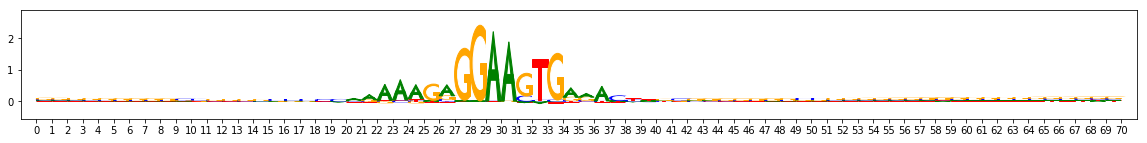

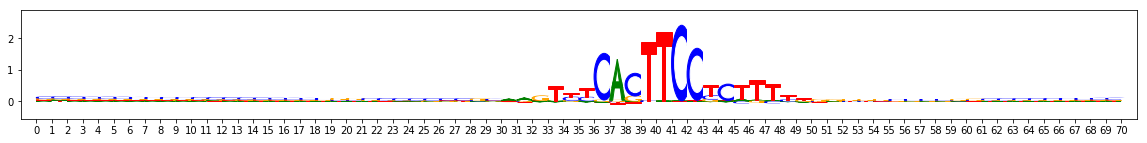

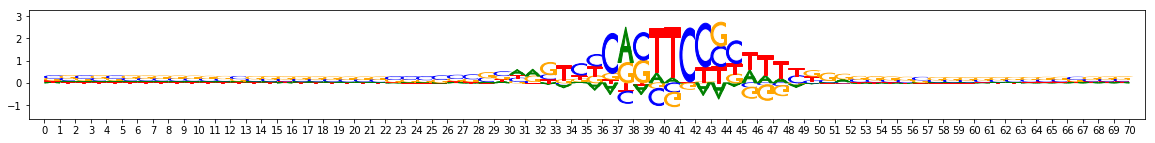

ic-scaled sequence


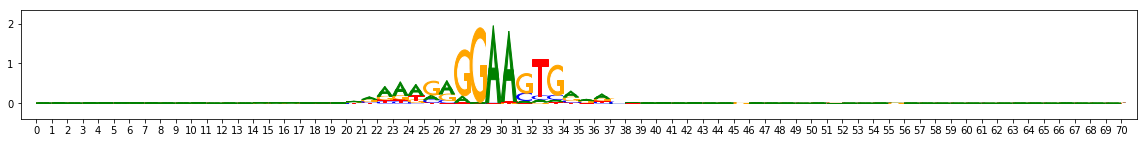

frequency sequence


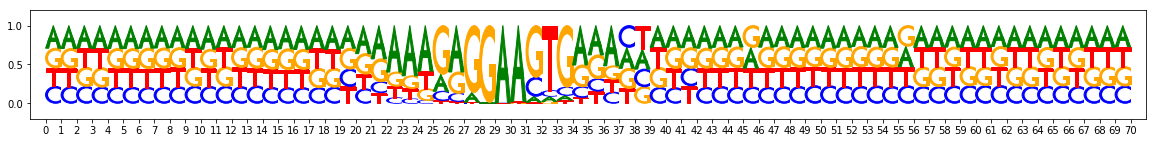

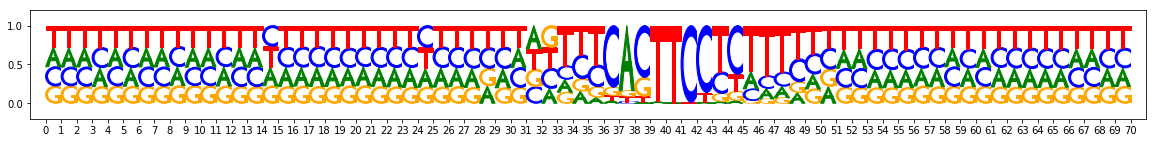

462
Contrib scores


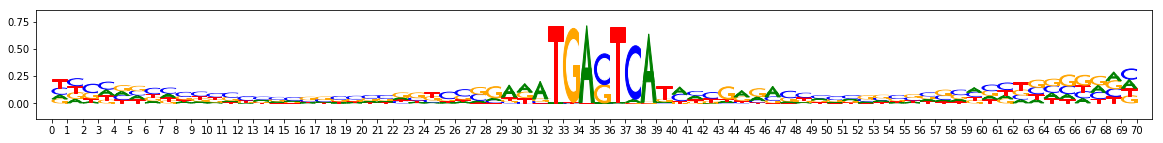

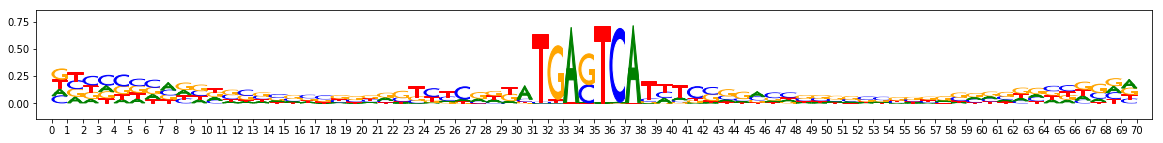

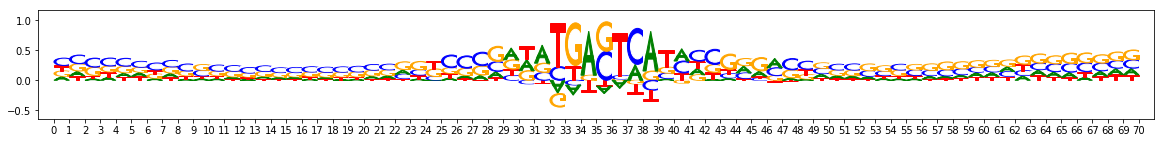

ic-scaled sequence


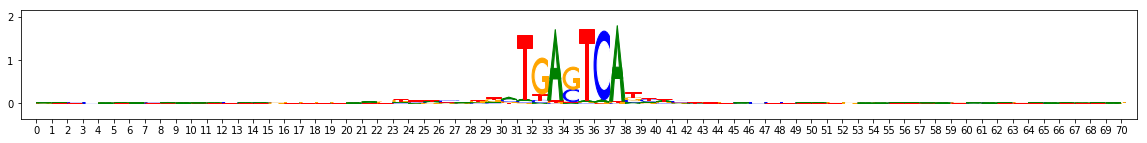

frequency sequence


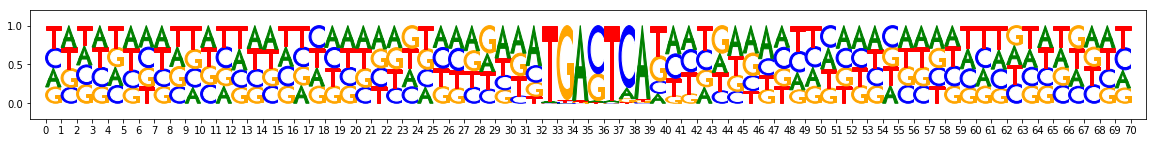

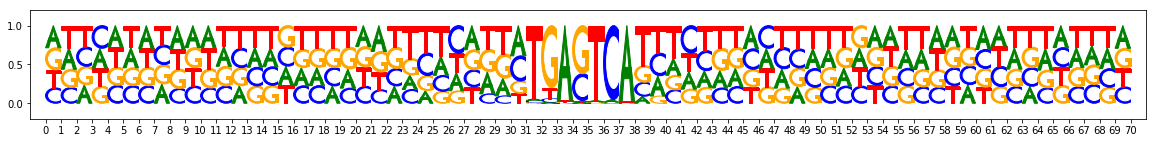

In [112]:
from modisco.visualization import viz_sequence
tfmodisco_patterns = loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results['metacluster_0'].seqlets_to_patterns_result.patterns

for pattern in tfmodisco_patterns[:2]:
    print(len(pattern.seqlets))
    print("Contrib scores")
    viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
    viz_sequence.plot_weights(pattern["task0_contrib_scores"].rev)
    viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)
    viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].rev)
    print("ic-scaled sequence")
    viz_sequence.plot_weights(viz_sequence.ic_scale(pattern["sequence"].fwd, background=acgt_freqs))
    viz_sequence.plot_weights(viz_sequence.ic_scale(pattern["sequence"].rev, background=acgt_freqs))
    print("frequency sequence")
    viz_sequence.plot_weights(pattern["sequence"].fwd)
    viz_sequence.plot_weights(pattern["sequence"].rev)

1297


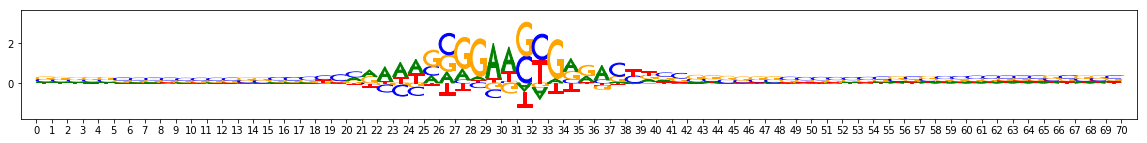

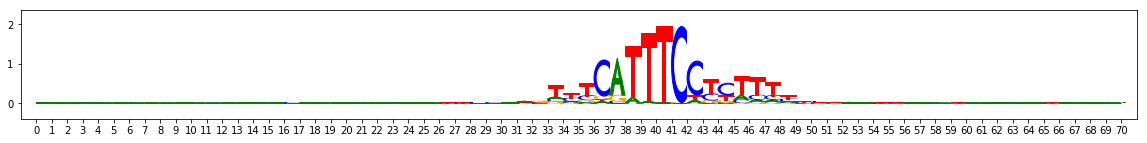

In [127]:

candidate_low_aff = []
for i,a_seqlet in enumerate(tfmodisco_patterns[0].seqlets):
    if a_seqlet["sequence"].fwd[31,1] != 1 and a_seqlet["sequence"].fwd[31,2] != 1:
        ranks.append(i)
        candidate_low_aff.append(a_seqlet)
print(len(candidate_low_aff))
lowaff = modisco.core.AggregatedSeqlet([modisco.core.SeqletAndAlignment(x,0) for x in candidate_low_aff])
viz_sequence.plot_weights(lowaff["task0_contrib_scores"].fwd)
viz_sequence.plot_weights(lowaff["task0_hypothetical_contribs"].fwd)
viz_sequence.plot_weights(viz_sequence.ic_scale(lowaff["sequence"].fwd, background=acgt_freqs))
viz_sequence.plot_weights(viz_sequence.ic_scale(lowaff["sequence"].rev, background=acgt_freqs))




2002


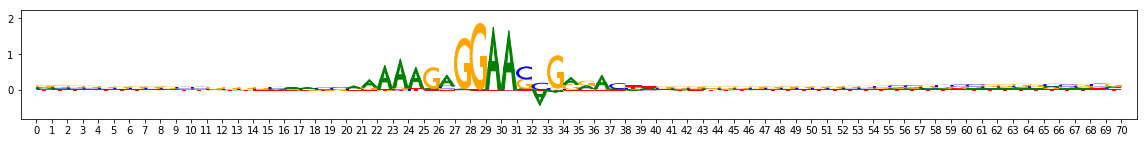

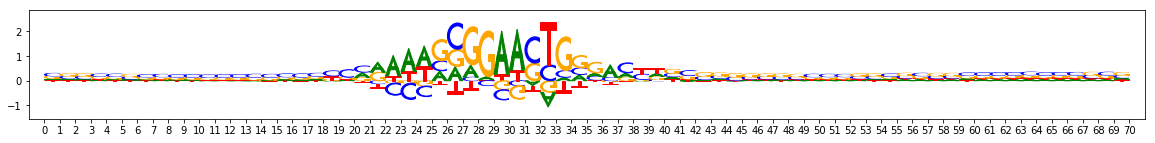

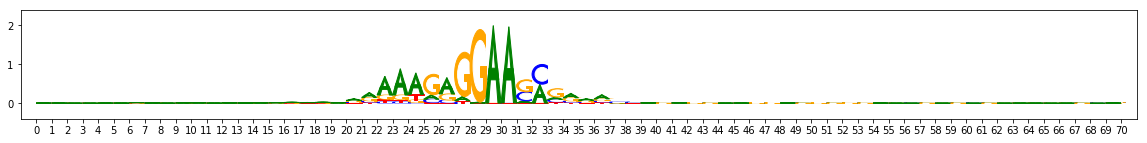

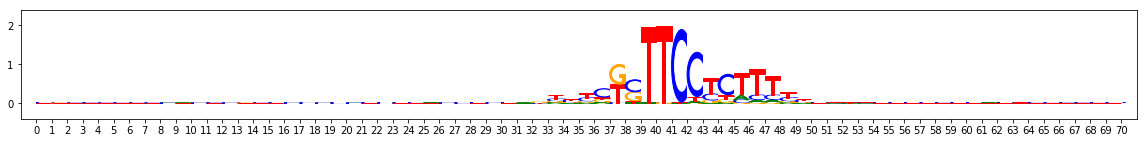

In [128]:
candidate_low_aff = []
for i,a_seqlet in enumerate(tfmodisco_patterns[0].seqlets):
    if a_seqlet["sequence"].fwd[32,2] != 1 and a_seqlet["sequence"].fwd[32,3] != 1:
        ranks.append(i)
        candidate_low_aff.append(a_seqlet)
print(len(candidate_low_aff))
lowaff = modisco.core.AggregatedSeqlet([modisco.core.SeqletAndAlignment(x,0) for x in candidate_low_aff])
viz_sequence.plot_weights(lowaff["task0_contrib_scores"].fwd)
viz_sequence.plot_weights(lowaff["task0_hypothetical_contribs"].fwd)
viz_sequence.plot_weights(viz_sequence.ic_scale(lowaff["sequence"].fwd, background=acgt_freqs))
viz_sequence.plot_weights(viz_sequence.ic_scale(lowaff["sequence"].rev, background=acgt_freqs))

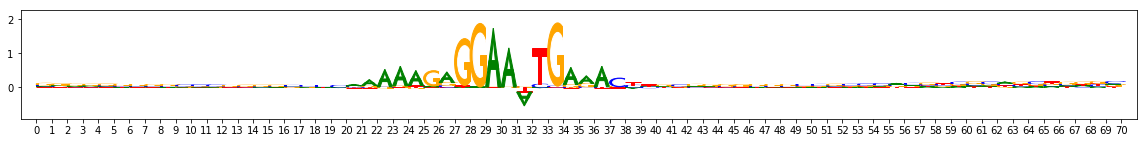

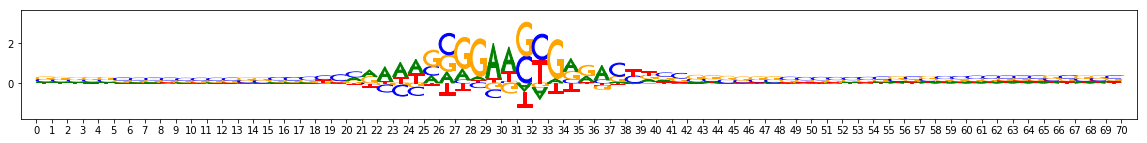

In [121]:
lowaff = modisco.core.AggregatedSeqlet([modisco.core.SeqletAndAlignment(x,0) for x in candidate_low_aff])
viz_sequence.plot_weights(lowaff["task0_contrib_scores"].fwd)
viz_sequence.plot_weights(lowaff["task0_hypothetical_contribs"].fwd)

In [107]:
factory = modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory()
seqlets_to_patterns = factory(track_set=track_set,
                              onehot_track_name="sequence",
                              contrib_scores_track_names=["task0_contrib_scores"],
                              hypothetical_contribs_track_names=["task0_hypothetical_contribs"],
                              track_signs=np.array([1]),
                              other_comparison_track_names=[])

TfModiscoSeqletsToPatternsFactory: seed=1234


In [110]:
len(seqlets_to_patterns_result.patterns[0].seqlets)

1133

In [103]:
from modisco import aggregator
from modisco import affinitymat
from modisco import cluster
reload(aggregator)
pattern_splitter = aggregator.DetectSpuriousMerging(
            track_names=["task0_contrib_scores"],
            track_transformer=affinitymat.core.L1Normalizer(),
            affmat_from_1d=affinitymat.core.ContinJaccardSimilarity(
                            make_positive=True, verbose=False),
            diclusterer=cluster.core.LouvainCluster(
                            level_to_return=1,
                            max_clusters=2, contin_runs=20,
                            verbose=False, seed=1234),
            is_dissimilar_func=aggregator.PearsonCorrIsDissimilarFunc(
                        threshold=0.8,
                        verbose=True),
            min_in_subcluster=10, verbose=True)

In [ ]:
print(split1)

The PWM HOMER_denovo


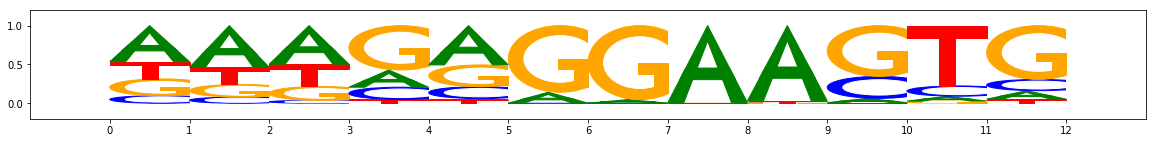

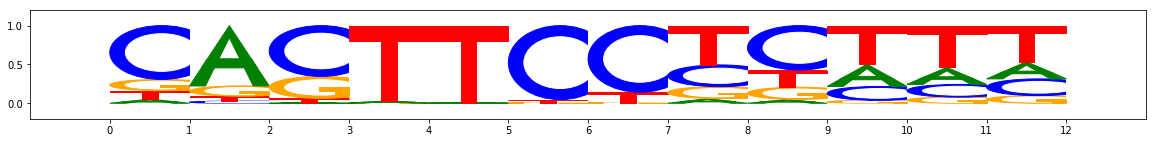

BQTL(chrom='chr13', chrom_start=101457533, region_idx=7468, offset=491, alt_allele='C', post_allele='A', pval=9.1052030929498e-05)
HOMER_denovo


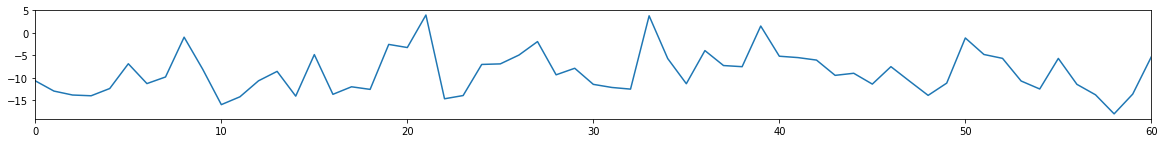

M4475_1.02


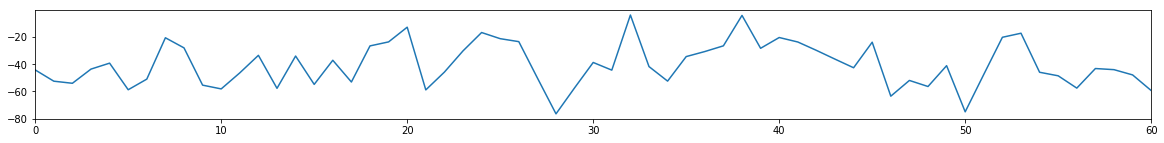

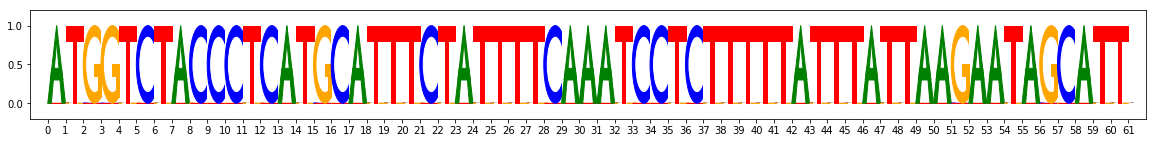

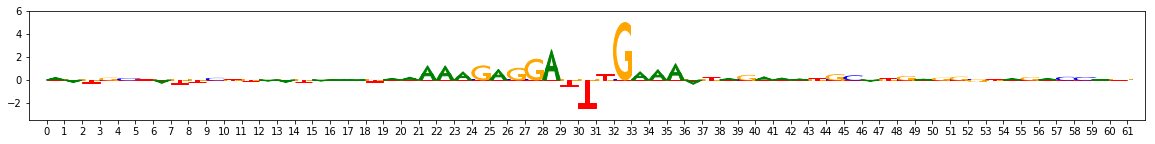

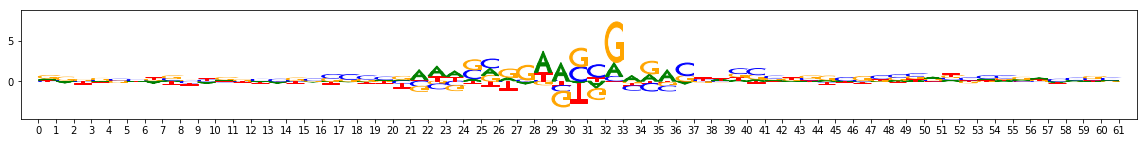

BQTL(chrom='chr5', chrom_start=107857272, region_idx=27977, offset=506, alt_allele='A', post_allele='G', pval=1.59931822076637e-06)
HOMER_denovo


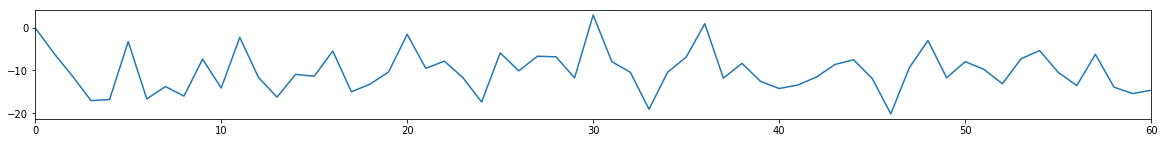

M4475_1.02


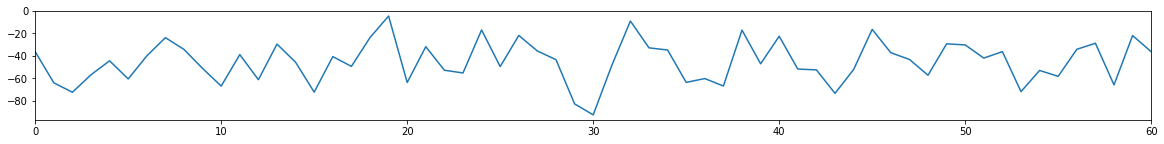

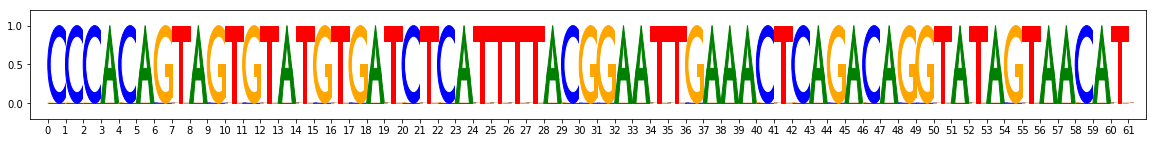

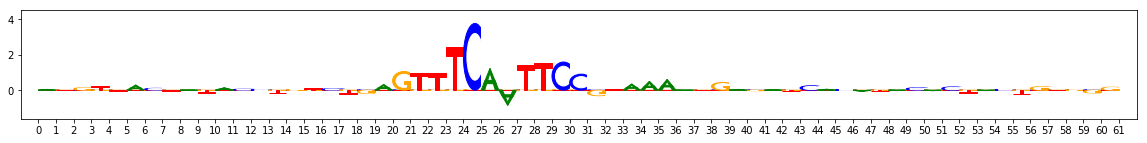

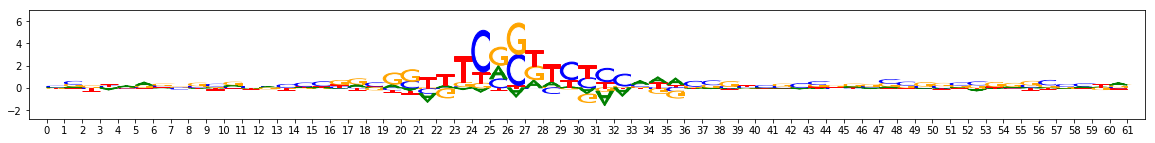

BQTL(chrom='chr13', chrom_start=39988712, region_idx=6800, offset=508, alt_allele='C', post_allele='T', pval=4.15970006959736e-18)
HOMER_denovo


M4475_1.02


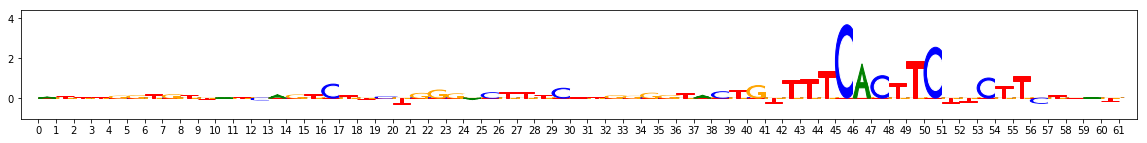

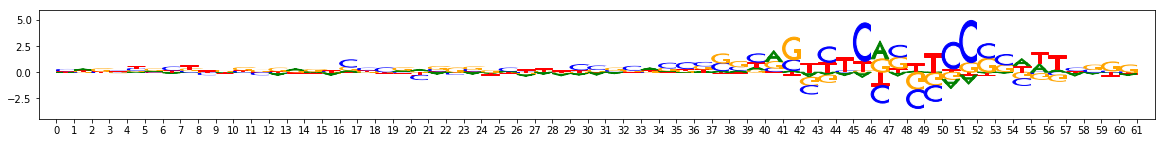

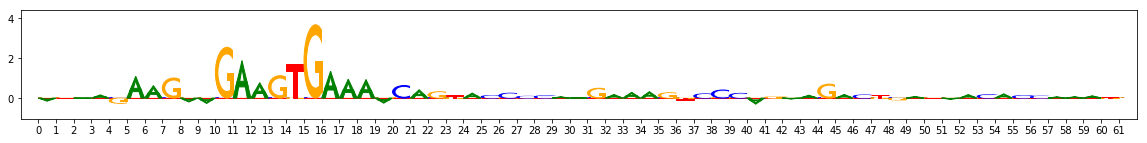

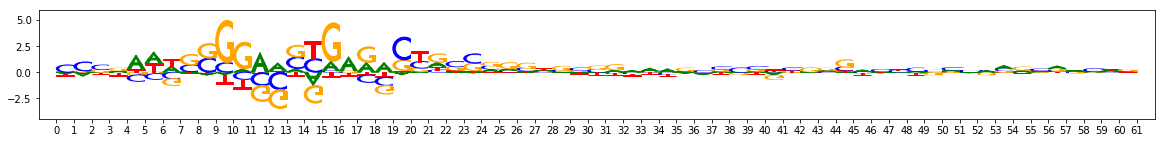

BQTL(chrom='chr12', chrom_start=82999144, region_idx=5542, offset=535, alt_allele='G', post_allele='A', pval=1.44833737938036e-08)
HOMER_denovo


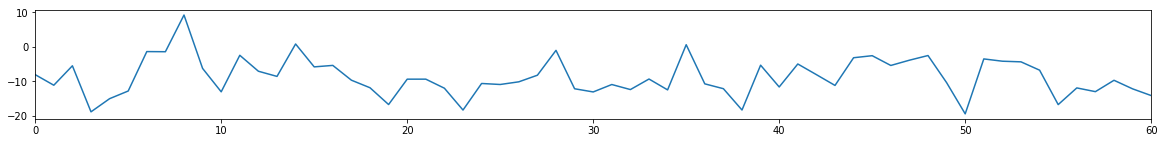

M4475_1.02


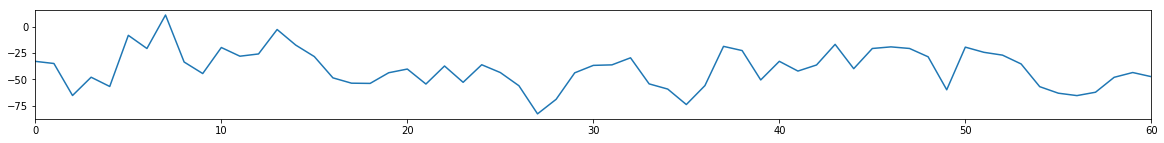

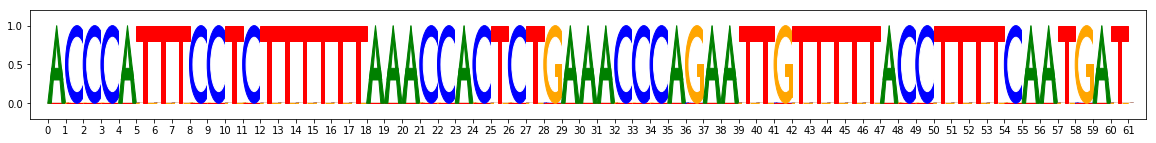

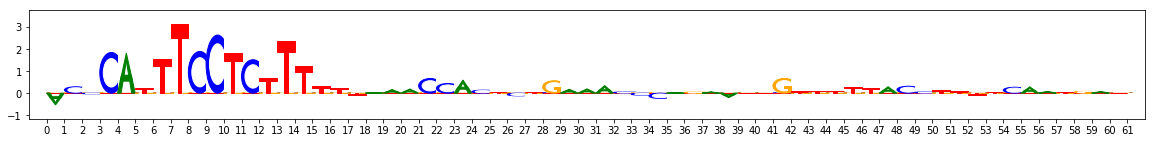

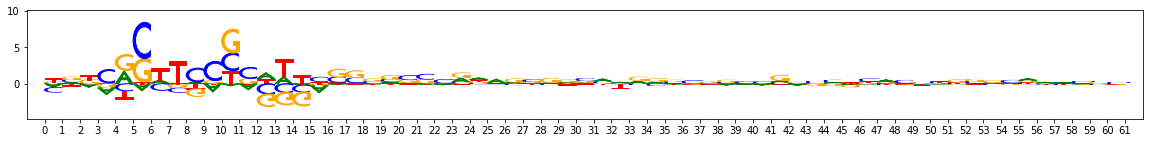

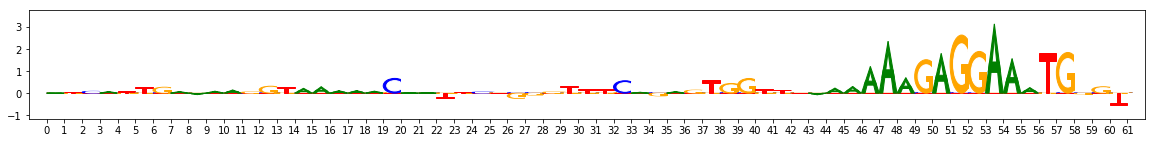

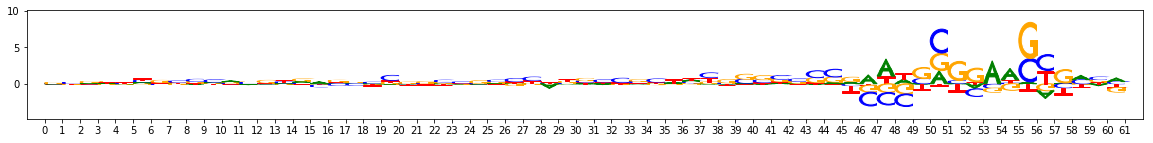

BQTL(chrom='chr18', chrom_start=56168483, region_idx=14196, offset=524, alt_allele='C', post_allele='T', pval=2.33999646611267e-05)
HOMER_denovo


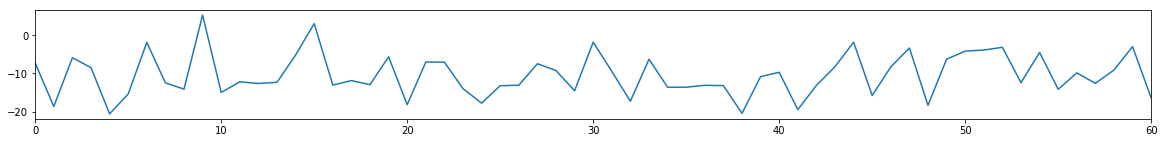

M4475_1.02


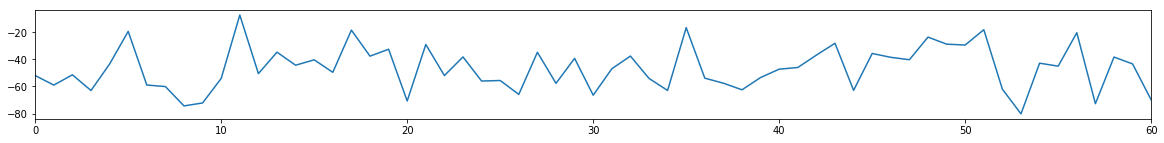

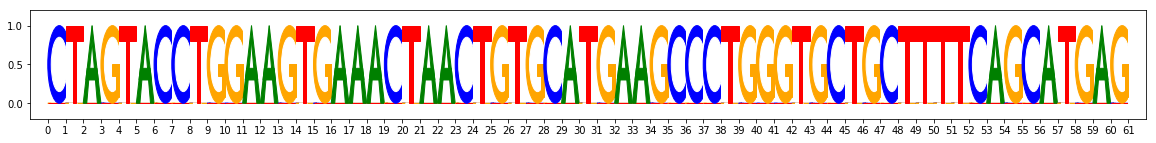

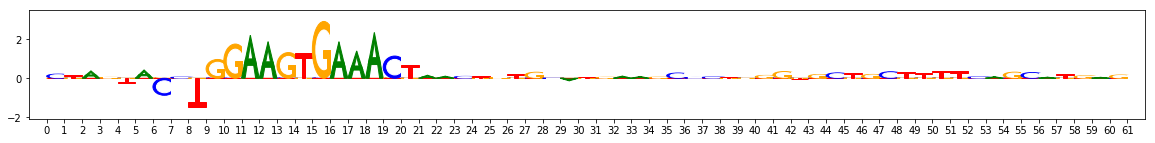

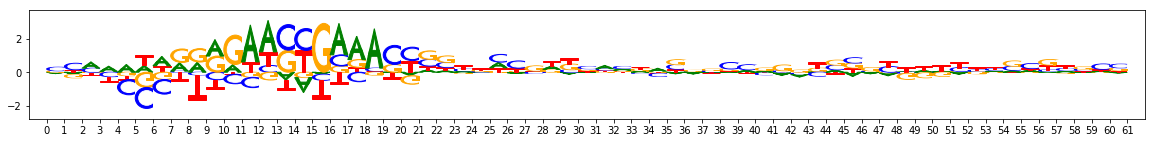

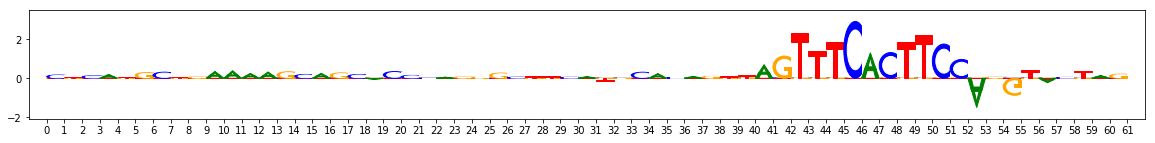

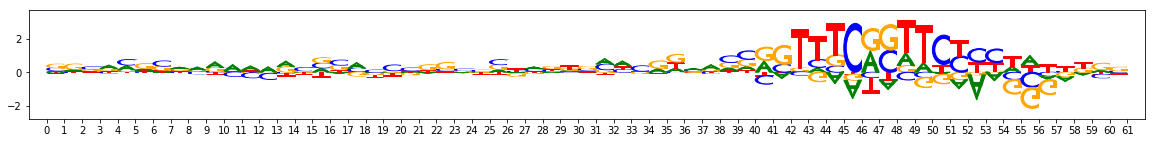

BQTL(chrom='chr10', chrom_start=85703896, region_idx=1266, offset=494, alt_allele='A', post_allele='T', pval=6.99301141238284e-05)
HOMER_denovo


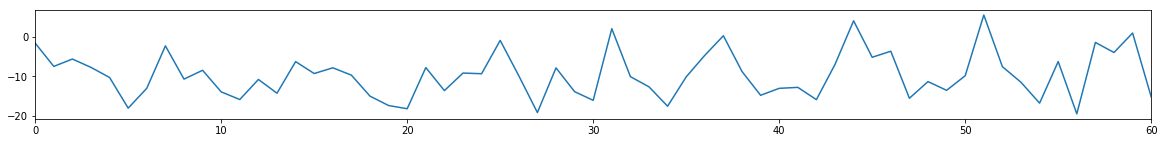

M4475_1.02


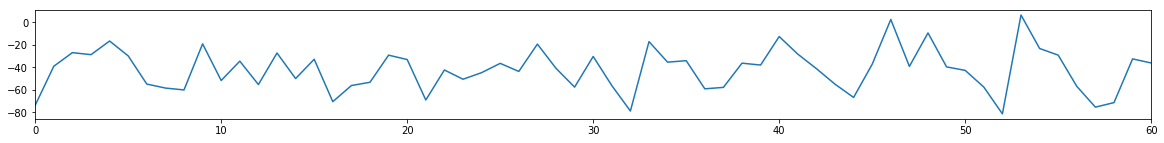

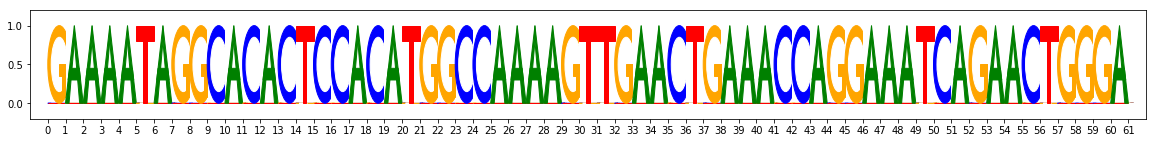

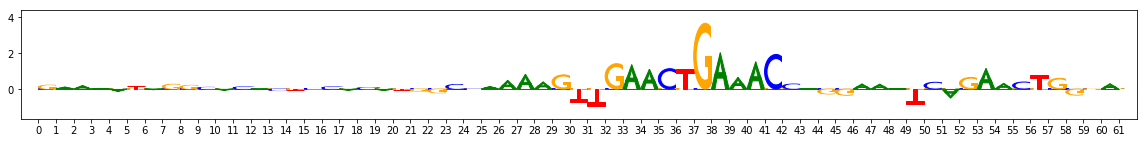

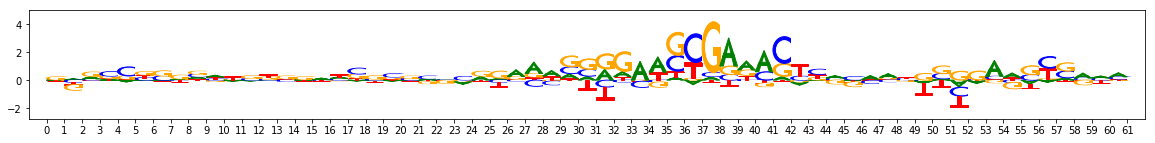

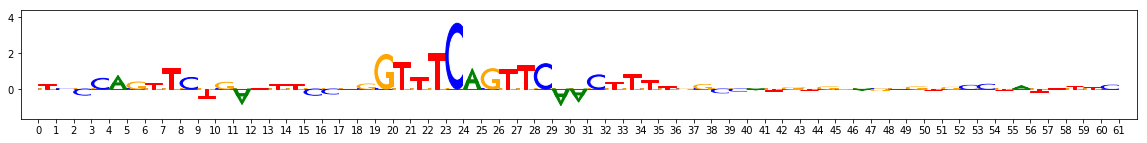

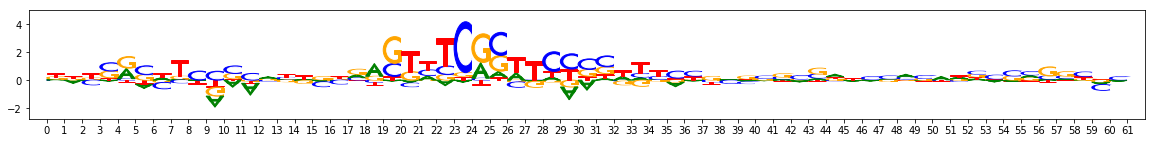

BQTL(chrom='chr17', chrom_start=42486309, region_idx=12643, offset=480, alt_allele='C', post_allele='T', pval=3.10317000161233e-38)
HOMER_denovo


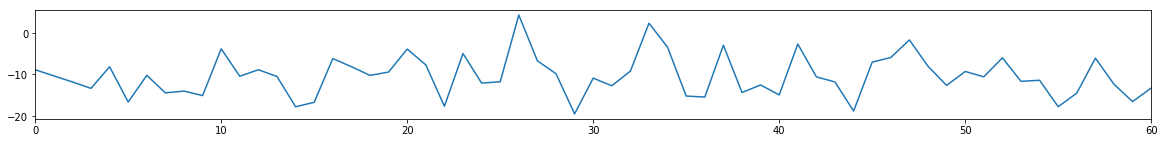

M4475_1.02


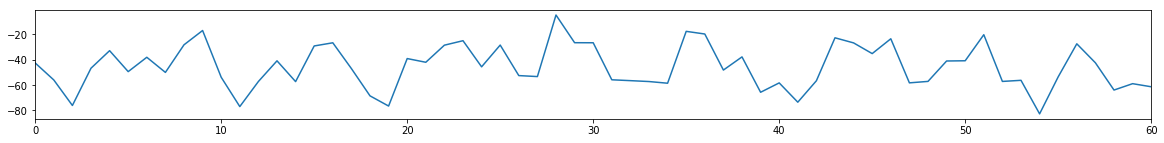

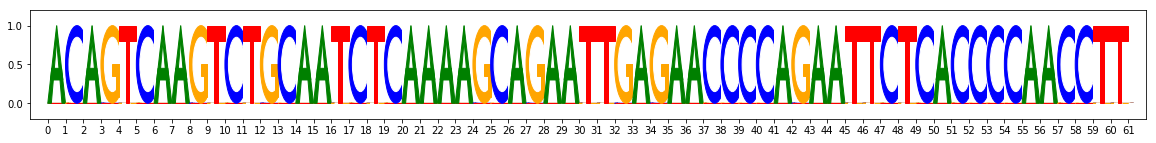

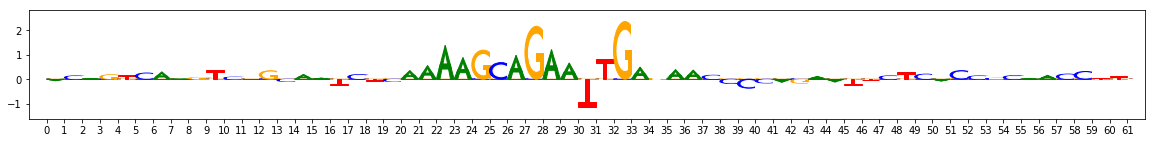

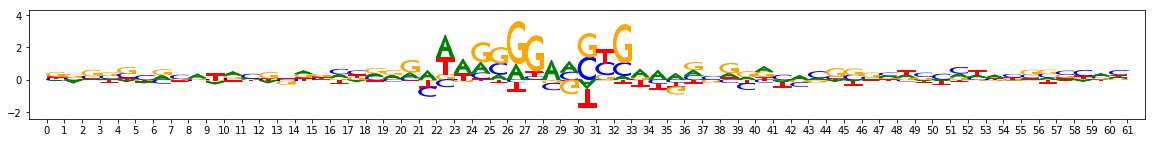

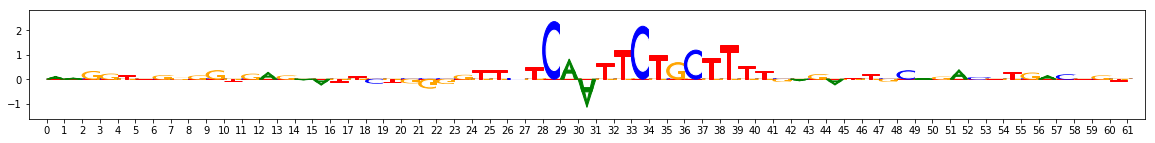

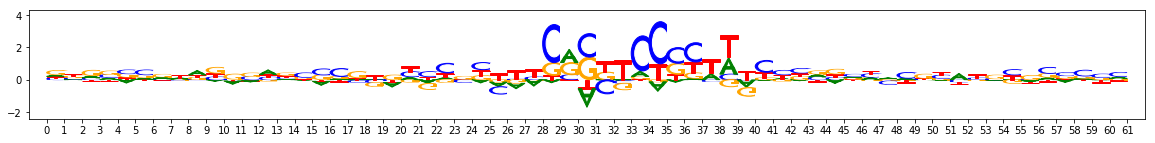

BQTL(chrom='chr12', chrom_start=53104734, region_idx=5145, offset=462, alt_allele='C', post_allele='T', pval=5.85993608043014e-05)
HOMER_denovo


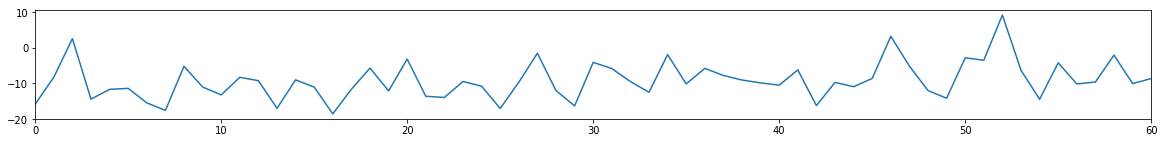

M4475_1.02


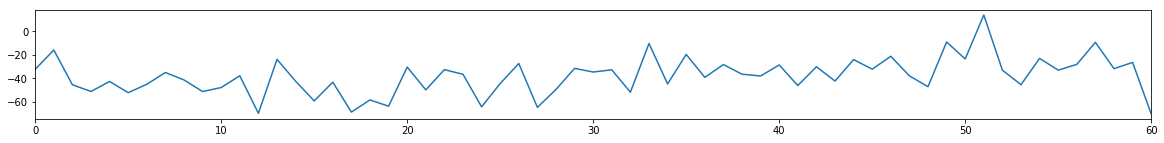

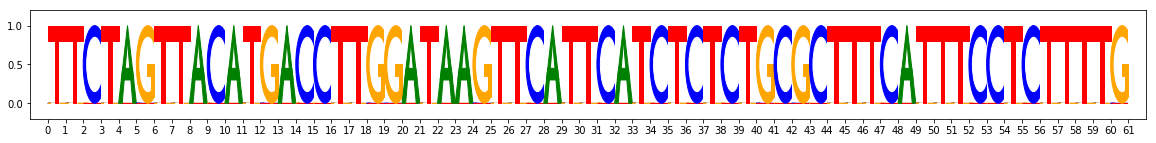

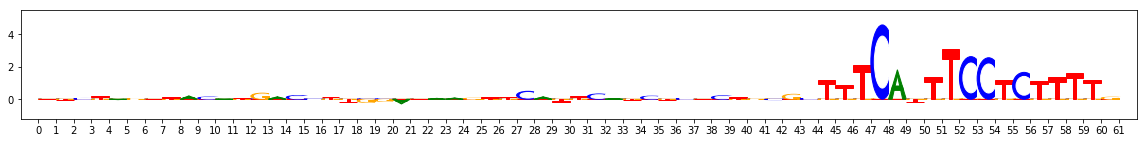

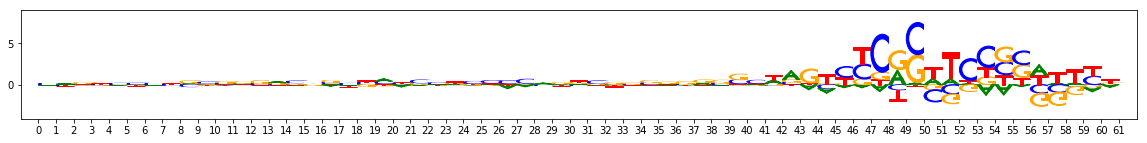

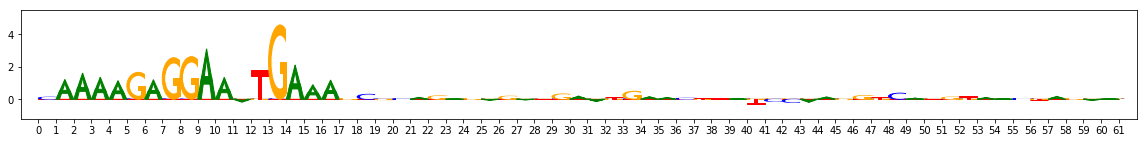

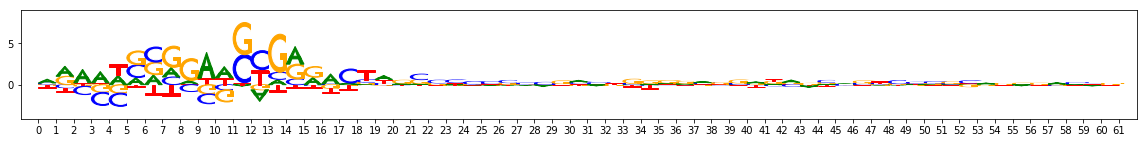

BQTL(chrom='chr7', chrom_start=26377031, region_idx=32376, offset=448, alt_allele='C', post_allele='G', pval=5.16219111822253e-09)
HOMER_denovo


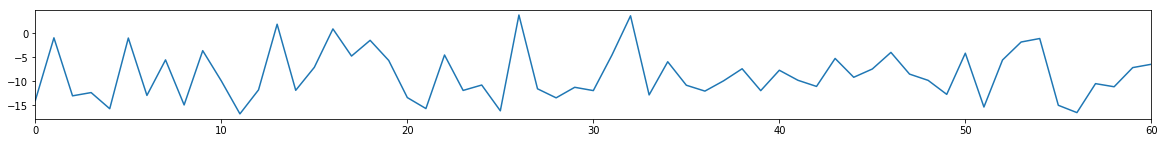

M4475_1.02


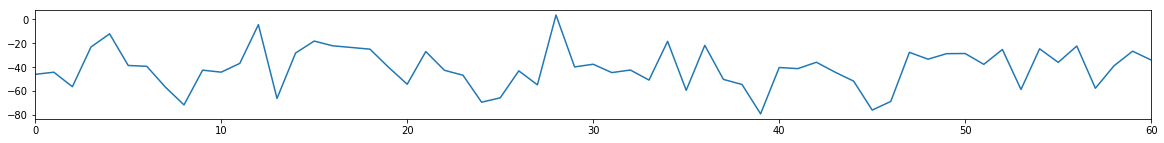

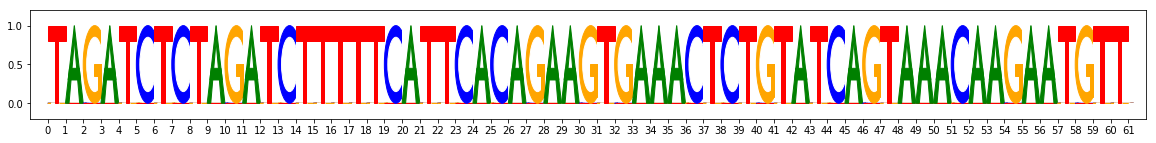

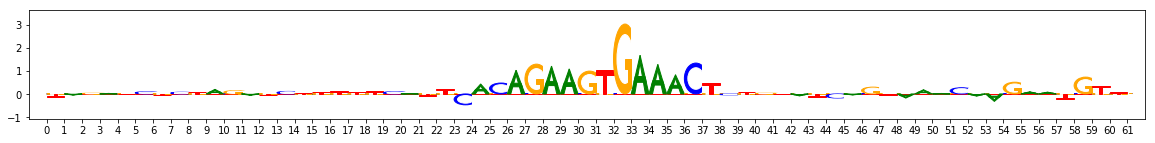

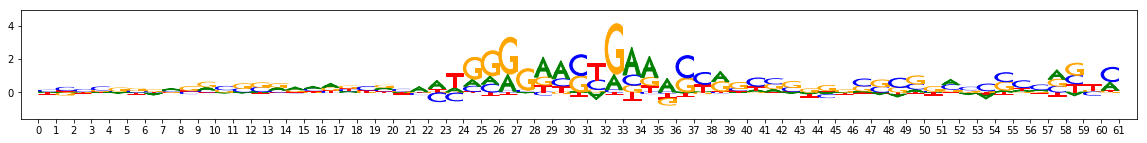

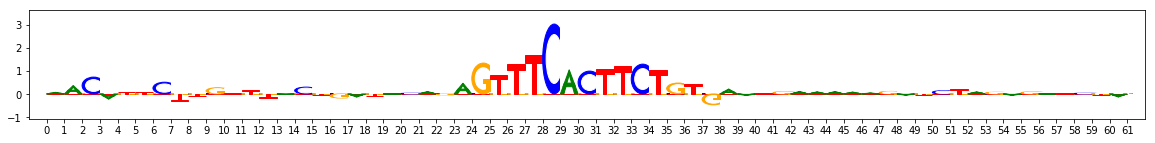

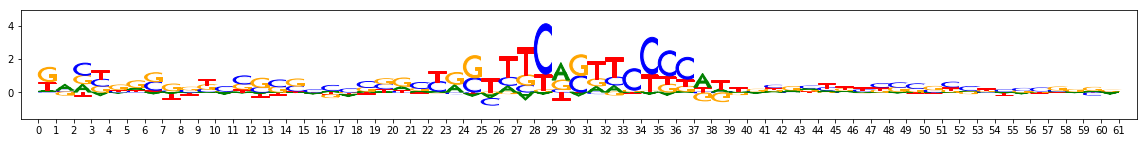

BQTL(chrom='chr6', chrom_start=27775946, region_idx=29822, offset=518, alt_allele='T', post_allele='C', pval=8.60699223993957e-06)
HOMER_denovo


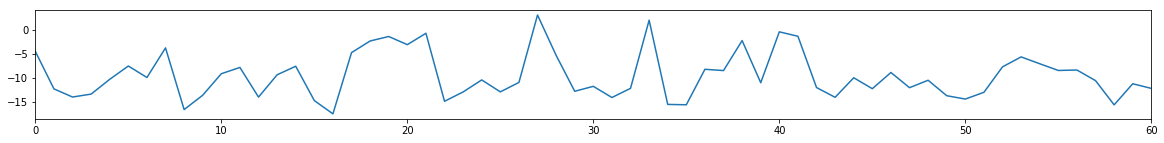

M4475_1.02


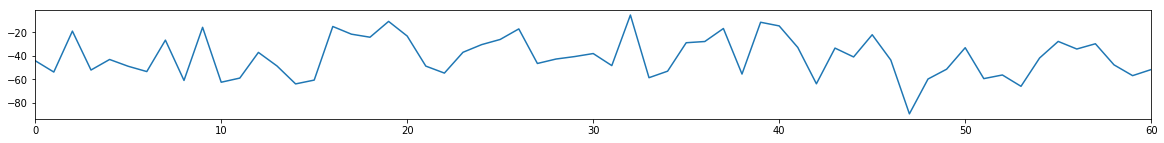

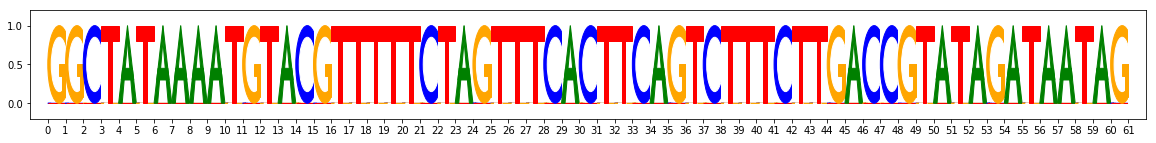

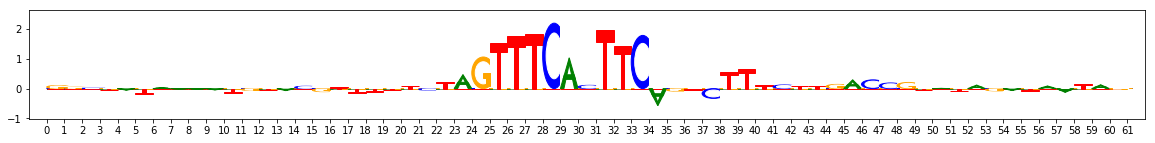

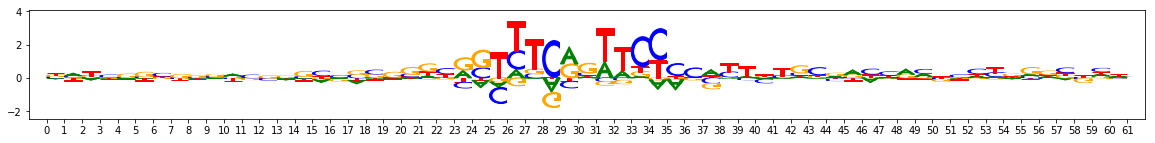

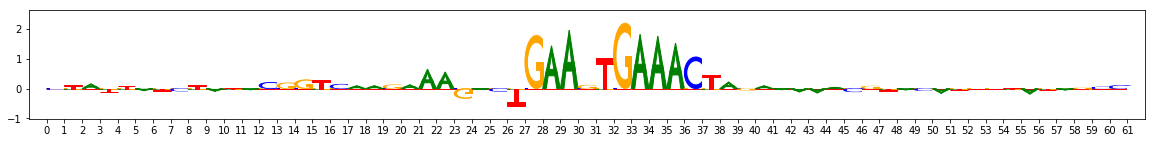

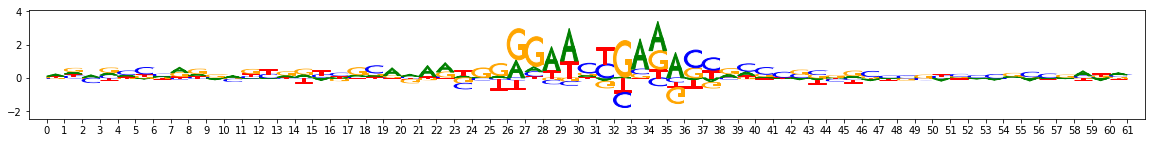

BQTL(chrom='chr17', chrom_start=72209493, region_idx=13204, offset=465, alt_allele='G', post_allele='T', pval=6.21020431982941e-06)
HOMER_denovo


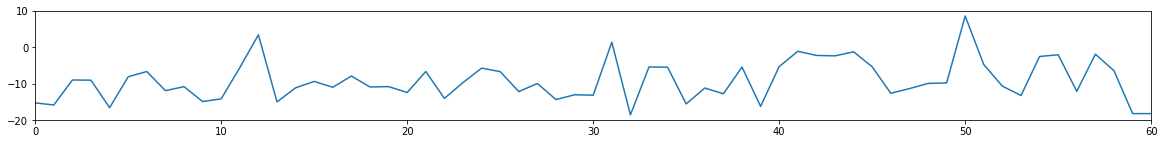

M4475_1.02


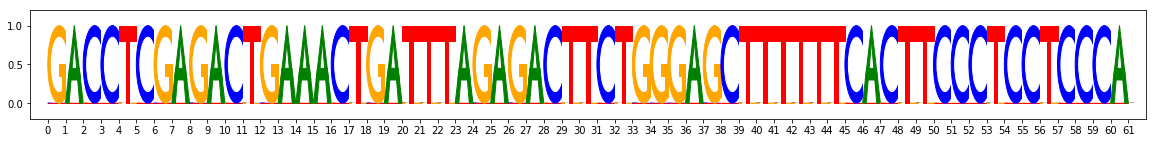

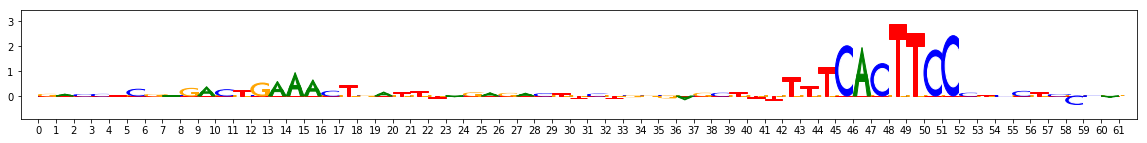

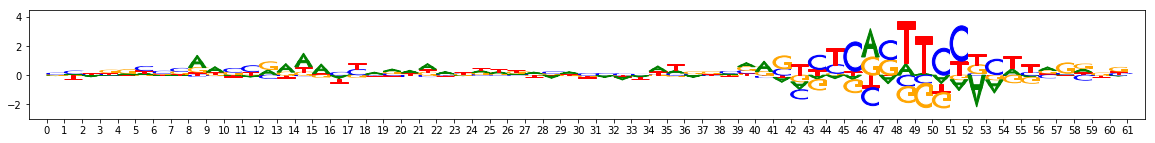

BQTL(chrom='chr13', chrom_start=42086793, region_idx=6852, offset=486, alt_allele='T', post_allele='C', pval=1.61262385151653e-05)
HOMER_denovo


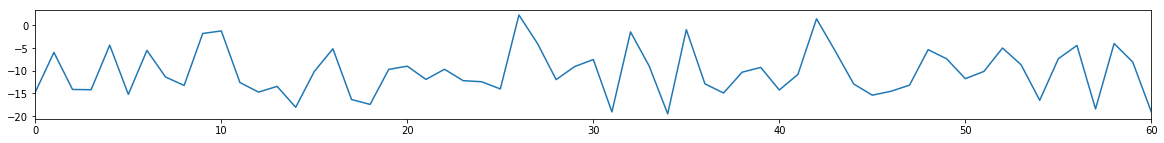

M4475_1.02


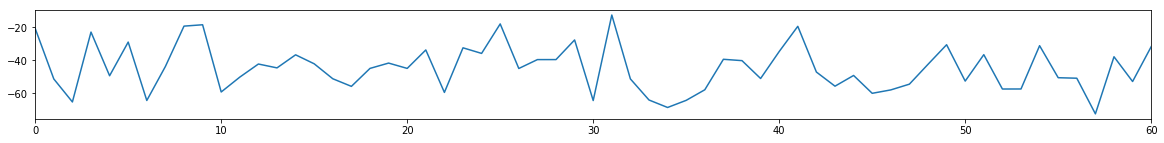

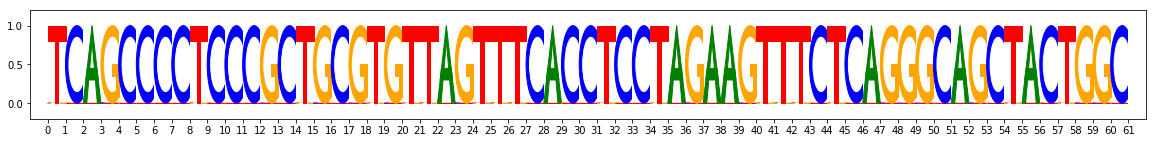

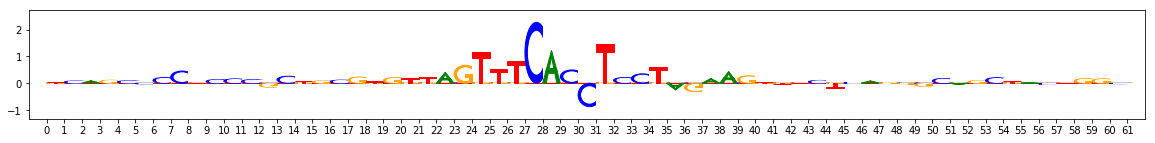

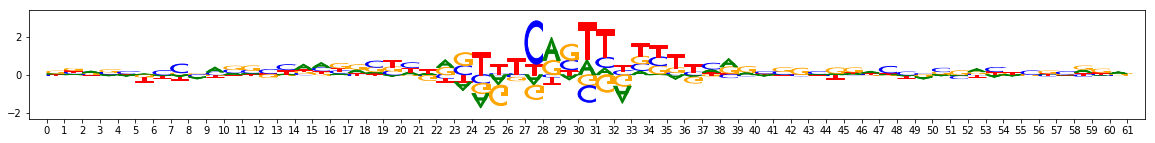

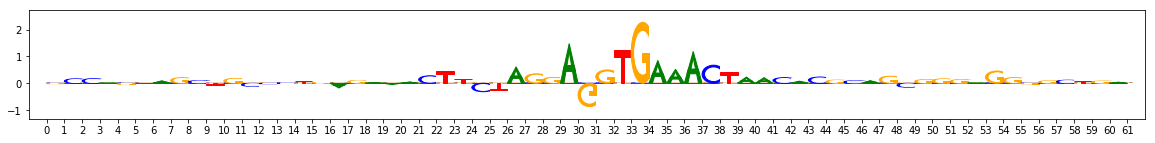

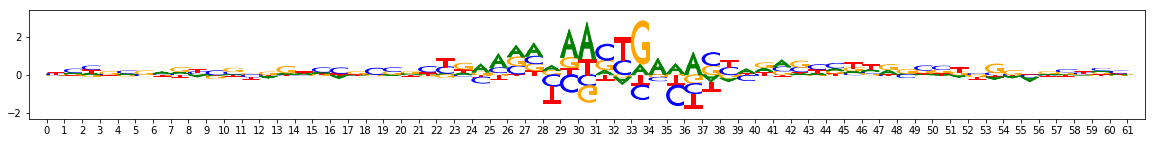

BQTL(chrom='chr13', chrom_start=99359774, region_idx=7411, offset=536, alt_allele='C', post_allele='T', pval=4.37693997596744e-10)
HOMER_denovo


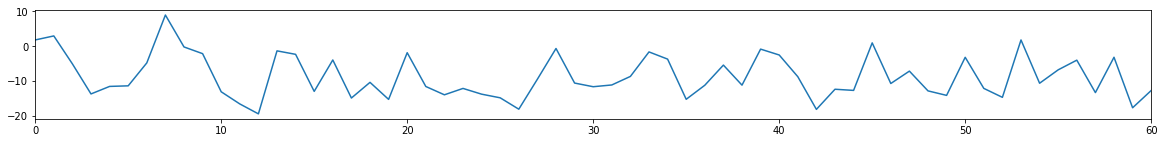

M4475_1.02


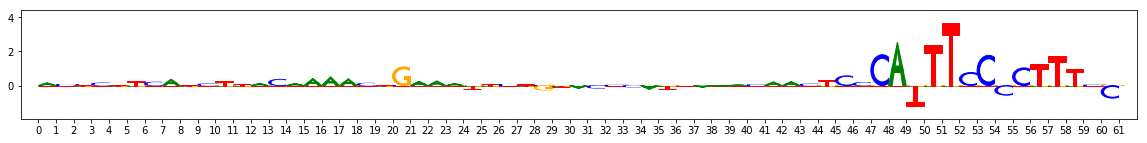

BQTL(chrom='chr2', chrom_start=99109131, region_idx=17365, offset=512, alt_allele='A', post_allele='G', pval=7.07797105391295e-09)
HOMER_denovo


M4475_1.02


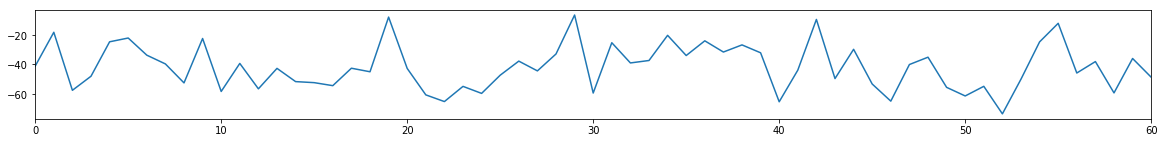

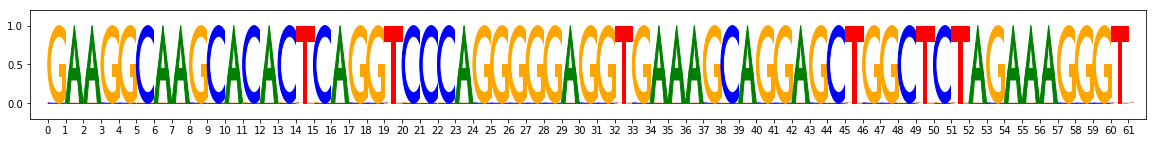

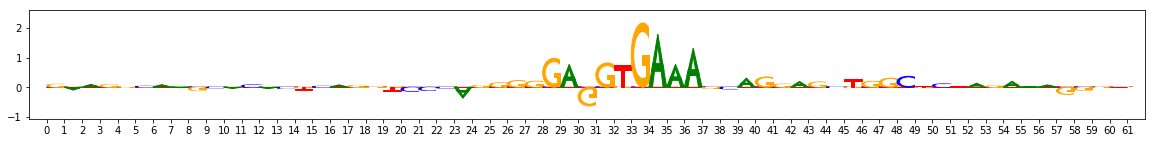

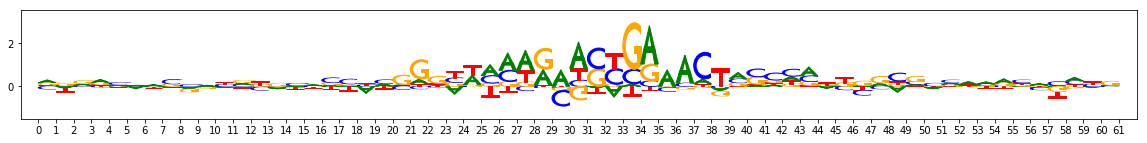

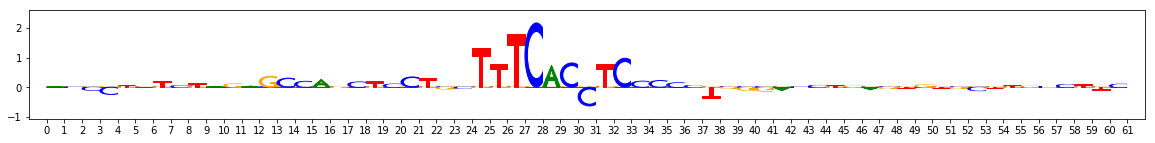

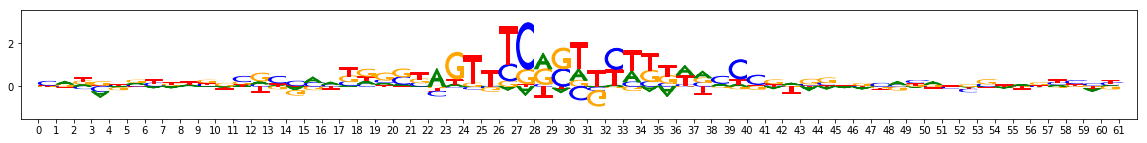

BQTL(chrom='chr6', chrom_start=13235791, region_idx=29469, offset=531, alt_allele='A', post_allele='G', pval=2.13017710531604e-09)
HOMER_denovo


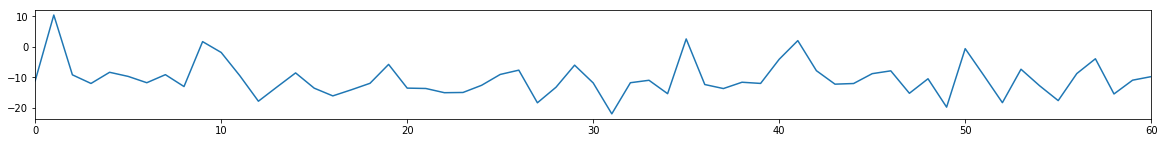

M4475_1.02


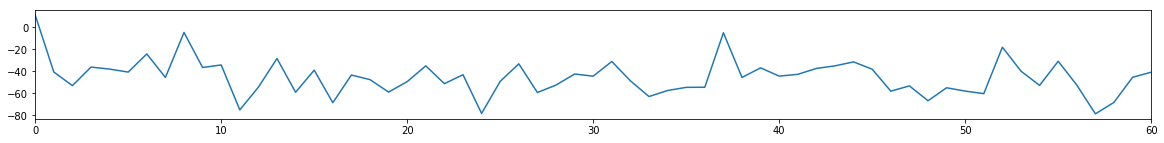

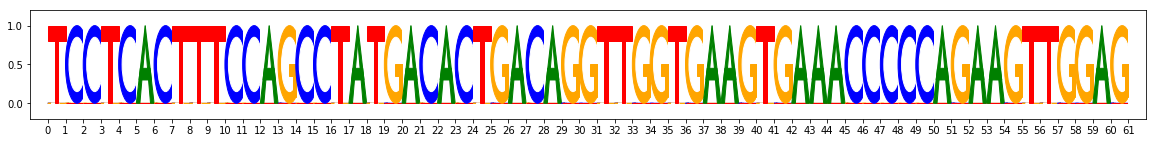

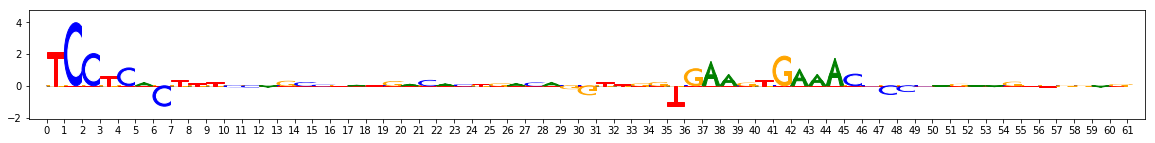

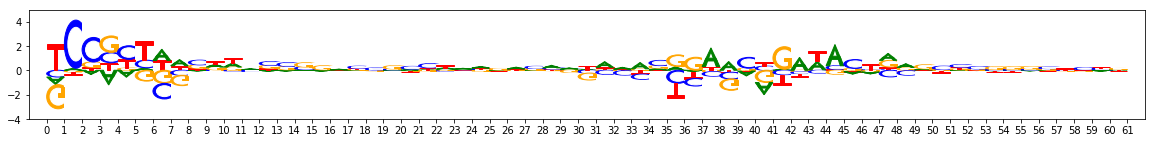

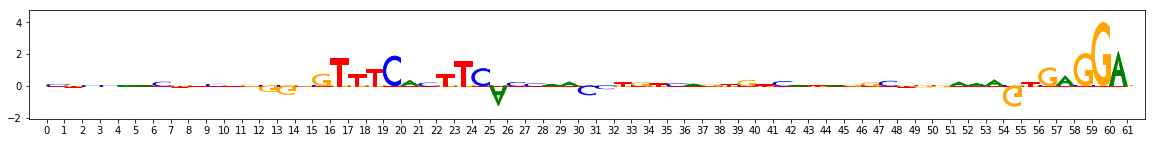

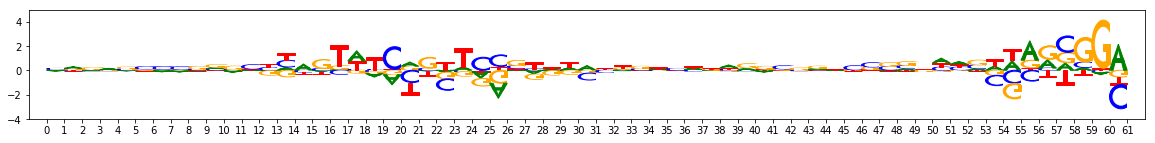

BQTL(chrom='chr22', chrom_start=42836336, region_idx=21678, offset=522, alt_allele='C', post_allele='A', pval=9.77615350320273e-08)
HOMER_denovo


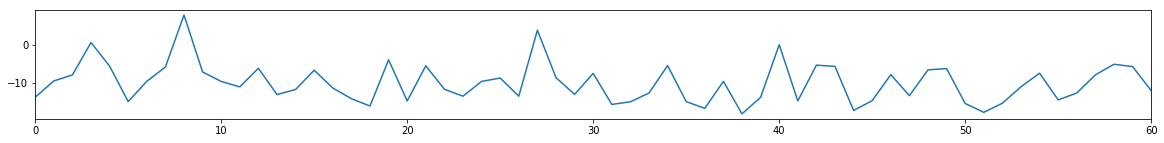

M4475_1.02


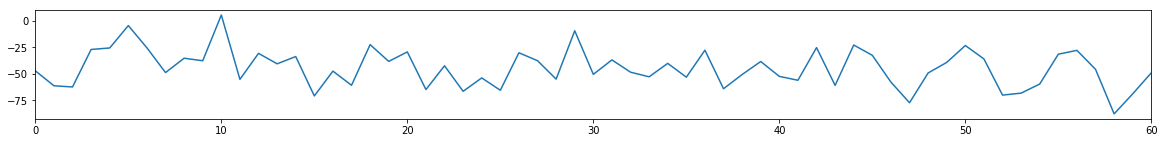

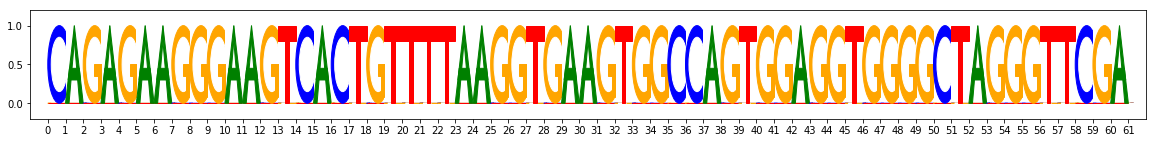

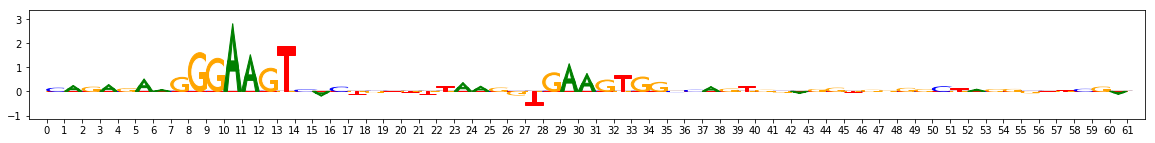

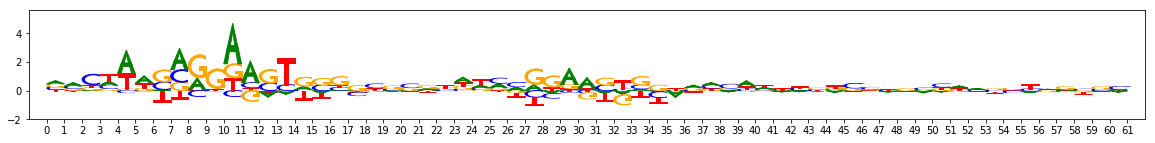

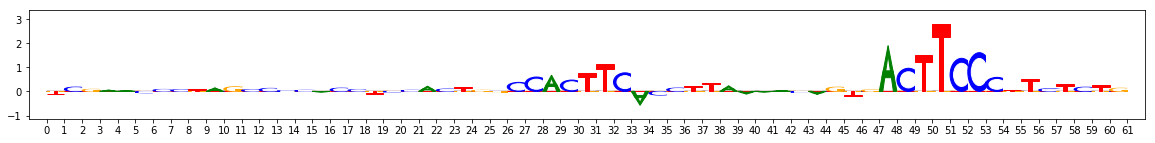

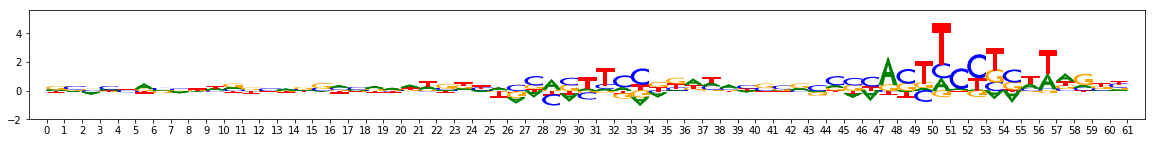

BQTL(chrom='chr7', chrom_start=95344813, region_idx=33177, offset=526, alt_allele='A', post_allele='G', pval=4.82930951778912e-05)
HOMER_denovo


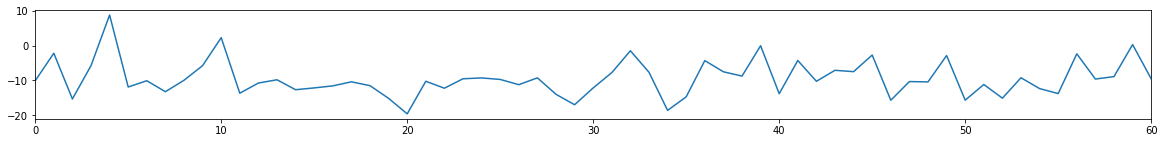

M4475_1.02


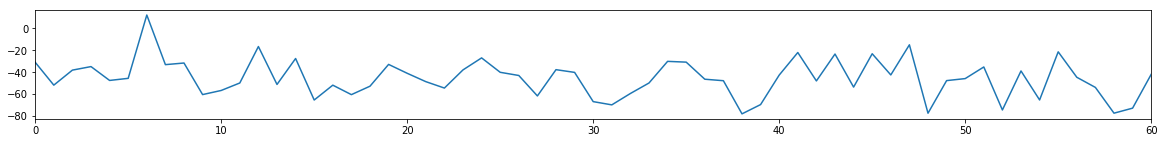

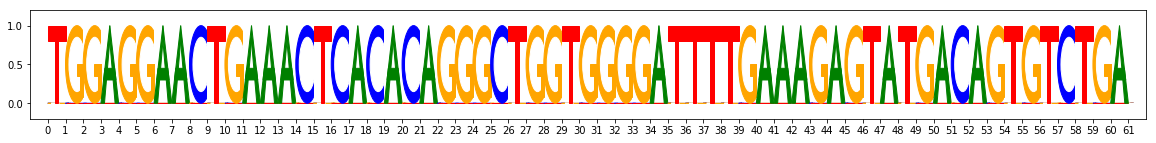

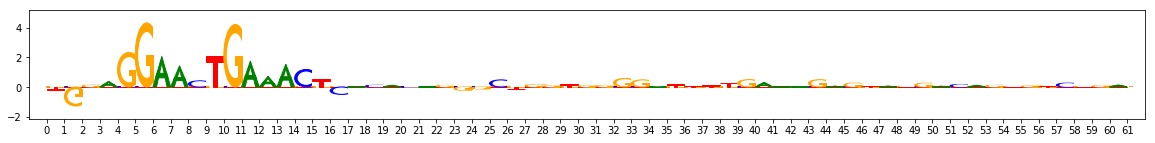

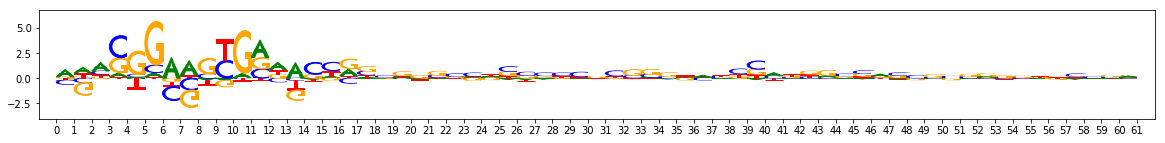

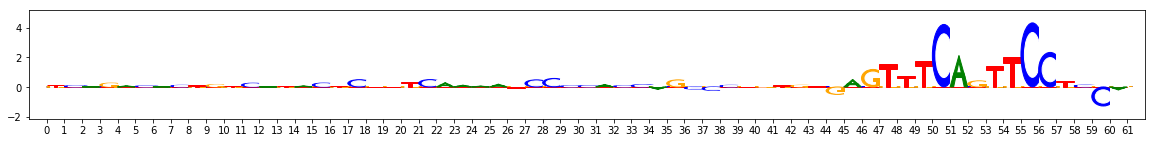

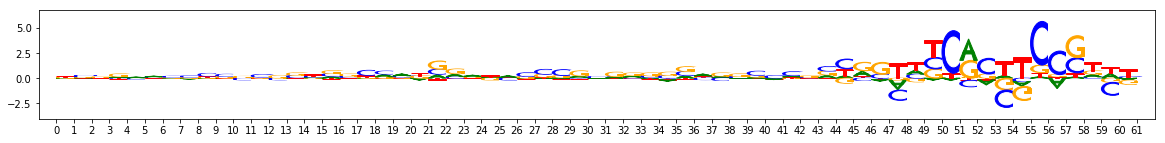

BQTL(chrom='chr4', chrom_start=86623430, region_idx=25626, offset=523, alt_allele='G', post_allele='C', pval=7.39901619566494e-18)
HOMER_denovo


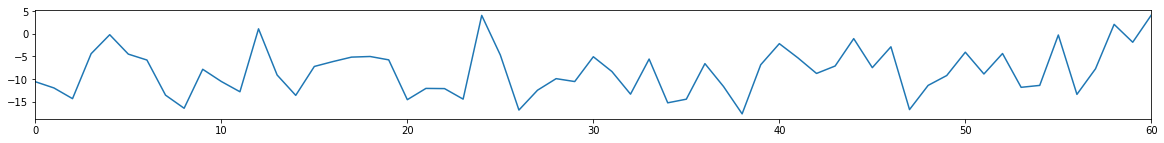

M4475_1.02


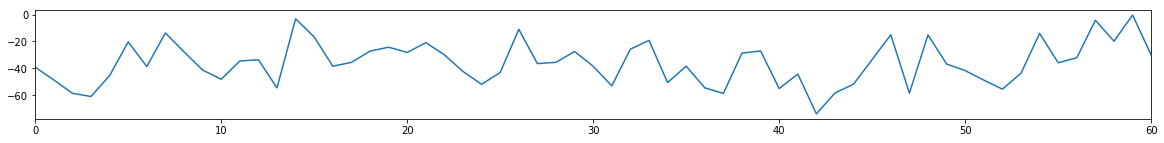

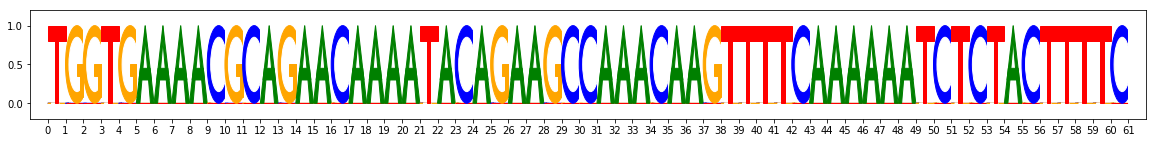

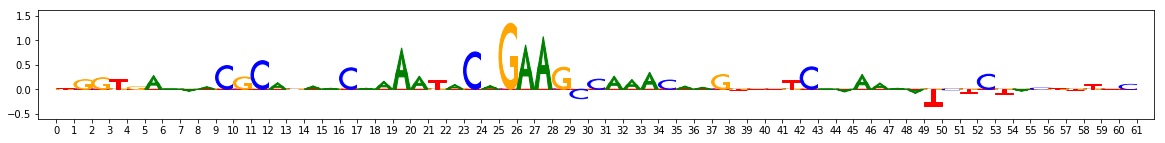

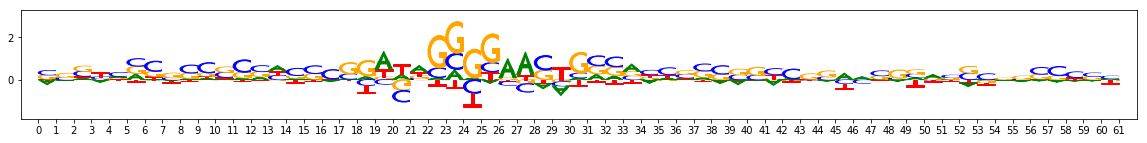

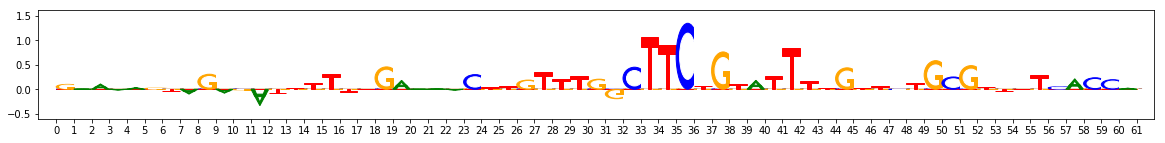

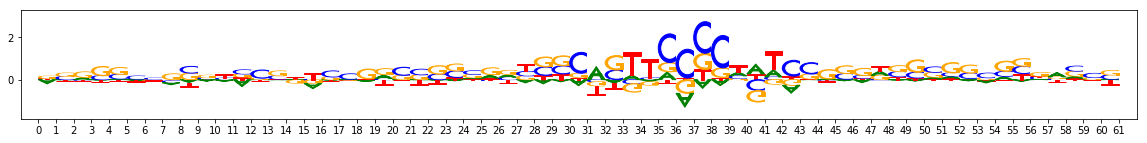

BQTL(chrom='chr7', chrom_start=64853052, region_idx=32808, offset=544, alt_allele='C', post_allele='T', pval=7.49918321030199e-05)
HOMER_denovo


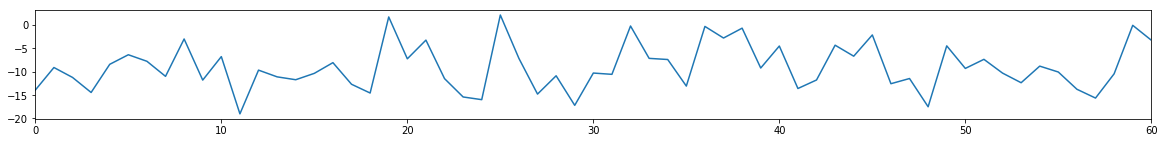

M4475_1.02


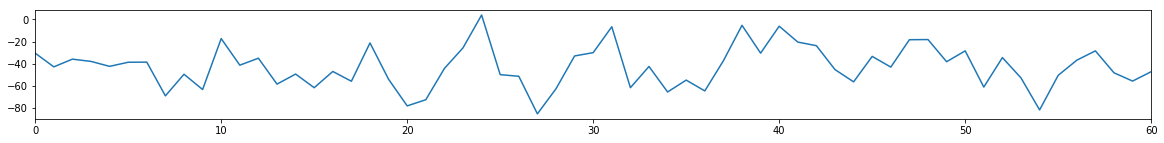

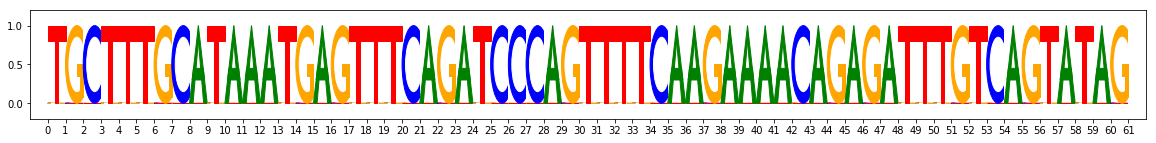

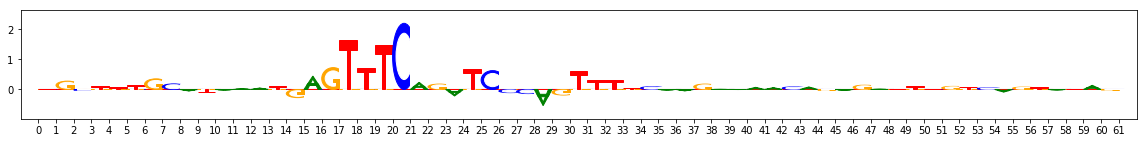

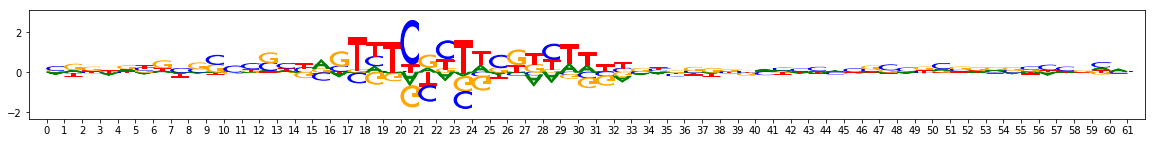

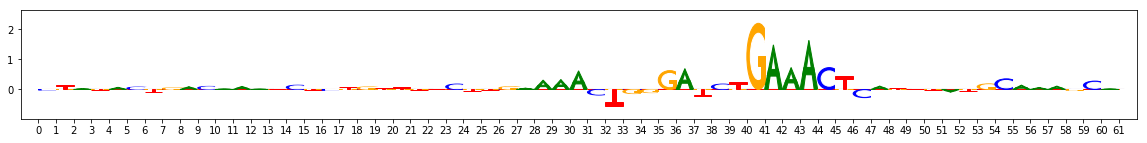

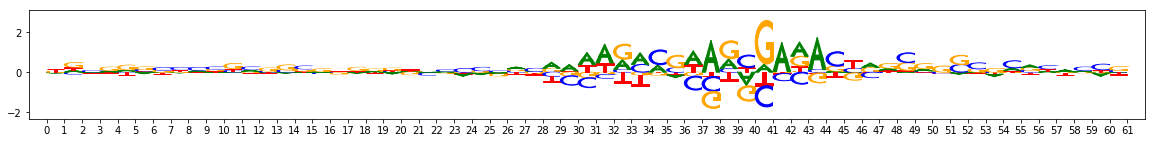

BQTL(chrom='chr20', chrom_start=48585957, region_idx=20345, offset=493, alt_allele='T', post_allele='C', pval=8.81600224494135e-29)
HOMER_denovo


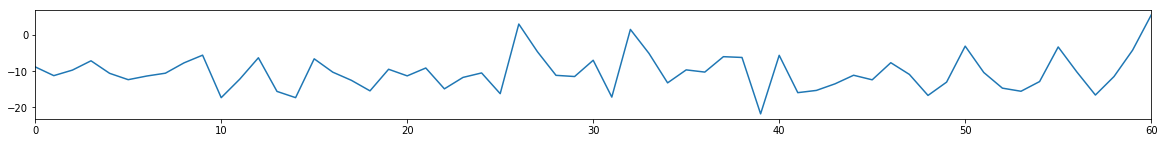

M4475_1.02


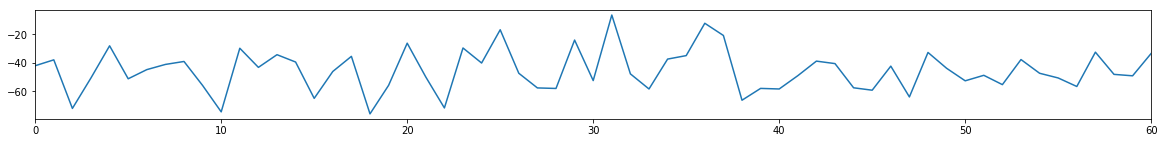

KeyboardInterrupt: 

In [115]:

import sys

font = {'size'   : 10}
matplotlib.rc('font', **font)

for pwm_name in ["HOMER_denovo", 'M4475_1.02']:
    print("The PWM", pwm_name)
    viz_sequence.plot_weights(pwm_name_to_matrix[pwm_name])
    viz_sequence.plot_weights(pwm_name_to_matrix[pwm_name][::-1,::-1])

    idxs_missed_by_motifs = sorted(np.nonzero((percnormed_bqtl_pwm_scores[pwm_name] < 0.8) * (bqtl_neglog10_pvalues >= 4))[0],
                                   key=lambda x: -percnormed_bqtl_nearby_importance[x])


    for idx in idxs_missed_by_motifs[:20]:
        bqtl = all_bqtls[idx]
        print(bqtl)
        post_letter_idx = letter_to_idx[bqtl.post_allele]
        for pwm_name in sorted(pwm_scores.keys()):
            print(pwm_name)
            plt.figure(figsize=(20,2))
            plt.plot(pwm_scores[pwm_name][bqtl.region_idx,bqtl.offset-30:bqtl.offset+31])
            plt.xlim((0,60))
            plt.show()
        viz_sequence.plot_weights((onehot_data[bqtl.region_idx][bqtl.offset-30:bqtl.offset+31]))
        viz_sequence.plot_weights((onehot_data[bqtl.region_idx]*hypcontribs[bqtl.region_idx])[bqtl.offset-30:bqtl.offset+31])
        viz_sequence.plot_weights(hypcontribs[bqtl.region_idx][bqtl.offset-30:bqtl.offset+31])
        viz_sequence.plot_weights((onehot_data[bqtl.region_idx]*hypcontribs[bqtl.region_idx])[bqtl.offset-30:bqtl.offset+31][::-1,::-1])
        viz_sequence.plot_weights(hypcontribs[bqtl.region_idx][bqtl.offset-30:bqtl.offset+31][::-1,::-1])
    
